### This notebook was mostly used for rough work. All final work is in the functions files.

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
from functions import load_track_section, plot_track_2d, plot_track_3d, get_start, filter_for_track_section, euclid_distance, load_race_data_2023

In [3]:
# The important functions made in this notebook:

def vector_to_apex(df: pd.DataFrame, apex1: list, apex2: list):
    # apex is a list 0 index is x coord, 1 is the y coord

    df_new = df.copy()

    required_columns = ['WORLDFORWARDDIRX', 'WORLDFORWARDDIRY', 'WORLDPOSX', 'WORLDPOSY']
    
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"DataFrame must contain the following columns: {required_columns}")
    
    df_new['forward_vector'] = list(zip(df_new['WORLDFORWARDDIRX'], df_new['WORLDFORWARDDIRY']))
    df_new['world_pos'] = list(zip(df_new['WORLDPOSX'], df_new['WORLDPOSY']))

    df_new['apex_vector1'] = [(apex1[0] - pos[0], apex1[1] - pos[1]) for pos in df_new['world_pos']]
    df_new['apex_vector2'] = [(apex2[0] - pos[0], apex2[1] - pos[1]) for pos in df_new['world_pos']]

    def unit_vector(vector):
        """ Returns the unit vector of the vector.  """
        return vector / np.linalg.norm(vector)

    def angle_between(v1, v2):
        """ Returns the signed angle in degrees between vectors 'v1' and 'v2' clockwise. """
        v1_u = unit_vector(v1)
        v2_u = unit_vector(v2)
        
        # Compute the dot product and angle
        dot_product = np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)
        angle = np.arccos(dot_product)

        # Compute the cross product (determinant) in 2D to find the sign of the angle
        cross = v1_u[0] * v2_u[1] - v1_u[1] * v2_u[0]
        
        # If the cross product is negative, it means the angle is clockwise, so negate it
        if cross < 0:
            angle = -angle
        
        # Convert the angle from radians to degrees
        return np.degrees(angle)
    
    # Apply the angle function to calculate angles to both apexes
    df_new['angle_to_apex1'] = [angle_between(forward, apex) for forward, apex in zip(df_new['forward_vector'], df_new['apex_vector1'])]
    df_new['angle_to_apex2'] = [angle_between(forward, apex) for forward, apex in zip(df_new['forward_vector'], df_new['apex_vector2'])]

    # Euclidean distance function
    def euclid_distance(p1, p2):
        return np.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)

    # Calculate Euclidean distances to both apexes
    df_new['dist_to_apex1'] = [euclid_distance(pos, apex1) for pos in df_new['world_pos']]
    df_new['dist_to_apex2'] = [euclid_distance(pos, apex2) for pos in df_new['world_pos']]

    return df_new


def max_brake_pt(df: pd.DataFrame):
    df_new = df.copy()  # Use df.copy() to avoid mutating the original dataframe
    # required_columns = ['WORLDFORWARDDIRX', 'WORLDFORWARDDIRY', 'WORLDPOSX', 'WORLDPOSY']
    
    # if not all(col in df.columns for col in required_columns):
    #     raise ValueError(f"DataFrame must contain the following columns: {required_columns}")
    
    grouped = df.groupby(['SESSION_IDENTIFIER', 'LAP_NUM'])

    max_braking_points = []
    
    # Iterate through each group
    for (session_id, lap_num), group in grouped:
        # Find the first row with the maximum braking value
        max_braking_row = group.loc[group['BRAKE'].idxmax()]
        max_braking_points.append(max_braking_row)

    # Create a new DataFrame from the list of maximum braking points
    max_braking_df = pd.DataFrame(max_braking_points) #  columns=required_columns
    
    return max_braking_df

def max_steering_pt(df: pd.DataFrame):
    
    grouped = df.groupby(['SESSION_IDENTIFIER', 'LAP_NUM'])

    max_steering_points = []
    
    # Iterate through each group
    for (session_id, lap_num), group in grouped:
        # Find the first row with the maximum braking value
        max_steering_row = group.loc[abs(group['STEERING']).idxmax()]
        max_steering_points.append(max_steering_row)

    # Create a new DataFrame from the list of maximum braking points
    max_steering_df = pd.DataFrame(max_steering_points) #  columns=required_columns
    
    return max_steering_df


def find_first_steering_point(df: pd.DataFrame, threshold: float = 0.1): # still need to figure out the threshold amount (0.05 looks good for fast laps)
    # Group by session and lap
    grouped = df.groupby(['SESSION_IDENTIFIER', 'LAP_NUM'])
    
    # Create a list to store the first row where steering > 0.1 for each lap
    first_steering_points = []
    
    # Iterate over each group
    for (session_id, lap_num), group in grouped:
        # Find the first row where the steering value is greater than the threshold (0.1)
        first_steering_row = group[group['STEERING'] > threshold].head(1)
        
        # If there is such a row, append it to the list
        if not first_steering_row.empty:
            first_steering_points.append(first_steering_row)
    
    # Concatenate all rows to form the new DataFrame
    steering_df = pd.concat(first_steering_points, ignore_index=True)
    
    return steering_df


### Exploration

In [4]:
def load_race_data_2022(directory):
    df = pd.read_csv(directory + '/f1sim-data-2022.csv')
    return filter_for_track_section(df)

LOCAL_DATA_DIR = '../datasets'

race_data22 = load_race_data_2022(LOCAL_DATA_DIR)
race_data22.head()

,SESSION_IDENTIFIER,FRAME,LAP_NUM,SECTOR,LAP_DISTANCE,CURRENT_LAP_TIME_MS,SECTOR_1_TIME_MS,SECTOR_2_TIME_MS,LAP_TIME_MS,SECTOR_3_MS,...,ROLL,WORLDPOSX,WORLDPOSY,WORLDPOSZ,WORLDFORWARDDIRX,WORLDFORWARDDIRY,WORLDFORWARDDIRZ,WORLDRIGHTDIRX,WORLDRIGHTDIRY,WORLDRIGHTDIRZ
0,1.004555e+19,1403,1,0,243.045959,2844,29433,18320,86008,38255,...,-0.023934,287.412811,298.471619,1.760029,-24167.0,-12.0,-22126.0,22120.0,784.0,-24160.0
1,1.004555e+19,1408,1,0,266.444916,3111,29433,18320,86008,38255,...,-0.021614,304.667603,282.659576,1.781548,-23858.0,105.0,-22460.0,22456.0,708.0,-23851.0
2,1.004555e+19,1416,1,0,297.438477,3486,29433,18320,86008,38255,...,-0.018019,326.941986,261.094025,1.882867,-23467.0,101.0,-22867.0,22865.0,590.0,-23462.0
3,1.004555e+19,1418,1,0,306.238770,3603,29433,18320,86008,38255,...,-0.015977,333.254730,254.958725,1.920085,-23584.0,172.0,-22747.0,22746.0,523.0,-23579.0
4,1.004555e+19,1470,1,0,441.464752,6106,29433,18320,86008,38255,...,-0.012085,370.639648,141.009048,2.337044,10302.0,-150.0,-31104.0,31103.0,395.0,10300.0


In [118]:

race_data23 = load_race_data_2023(LOCAL_DATA_DIR, filter_for_section=True, remove_unused_cols=False)
# race_data23 = load_race_data_2023(LOCAL_DATA_DIR)
race_data23.head()

,SESSION_IDENTIFIER,FRAME,LAP_NUM,SECTOR,LAP_DISTANCE,CURRENT_LAP_TIME_MS,SECTOR_1_TIME_MS,SECTOR_2_TIME_MS,LAP_TIME_MS,SECTOR_3_MS,SPEED_KPH,THROTTLE,BRAKE,GEAR,ENGINE_RPM,STEERING,YAW,PITCH,ROLL,WORLDPOSX,WORLDPOSY,WORLDPOSZ,WORLDFORWARDDIRX,WORLDFORWARDDIRY,WORLDFORWARDDIRZ,WORLDRIGHTDIRX,WORLDRIGHTDIRY,WORLDRIGHTDIRZ
0,10034676866664400896.000000,1680,1,0,1.775714,16,30129,18569,87226.000000,38528.000000,294.000000,1.000000,0.030945,8.000000,10541.000000,-0.018082,-2.336760,0.004231,-0.025839,113.192245,465.303589,2.900799,-23615.000000,-138.000000,-22714.000000,22704.000000,846.000000,-23610.000000
1,10034676866664400896.000000,1681,1,0,5.864580,66,30129,18569,87226.000000,38528.000000,294.000000,1.000000,0.030945,8.000000,10547.000000,-0.018174,-2.333671,0.005806,-0.025955,116.142723,462.470612,2.874730,-23685.000000,-190.000000,-22641.000000,22630.000000,850.000000,-23681.000000
2,10034676866664400896.000000,1682,1,0,9.964501,116,30129,18569,87226.000000,38528.000000,295.000000,1.000000,0.031952,8.000000,10563.000000,-0.013687,-2.330126,0.005979,-0.024798,119.108170,459.637115,2.845881,-23765.000000,-195.000000,-22557.000000,22547.000000,812.000000,-23761.000000
3,10034676866664400896.000000,1683,1,0,14.072903,166,30129,18569,87226.000000,38528.000000,295.000000,1.000000,0.032959,8.000000,10581.000000,-0.000687,-2.327518,0.005315,-0.024717,122.087158,456.805298,2.821898,-23824.000000,-174.000000,-22495.000000,22485.000000,809.000000,-23820.000000
4,10034676866664400896.000000,1684,1,0,18.184681,216,30129,18569,87226.000000,38528.000000,296.000000,1.000000,0.032959,8.000000,10598.000000,0.004532,-2.326889,0.004296,-0.025042,125.073685,453.976288,2.798889,-23838.000000,-140.000000,-22480.000000,22471.000000,820.000000,-23833.000000


In [6]:
df_startpoint = get_start()
df_startpoint.head()

,WORLDPOSX,WORLDPOSY,WORLDPOSZ
0,109.943344,467.951904,3.136914


In [7]:
TRACK_END_X_MAX, TRACK_END_Y_MIN = 600, -50

In [8]:
track = load_track_section(LOCAL_DATA_DIR)
track.head()

,REFTYPE,SESSION_IDENTIFIER,FRAME,WORLDPOSX,WORLDPOSY,WORLDPOSZ
44,LEFT,18118509207215334066,899,155.774521,428.919189,2.753837
67,LEFT,18118509207215334066,1195,390.018829,200.663132,2.694468
68,LEFT,18118509207215334066,1196,390.178314,200.308243,2.695261
69,LEFT,18118509207215334066,1198,390.478394,199.589447,2.696533
70,LEFT,18118509207215334066,1200,390.795441,198.735016,2.698336


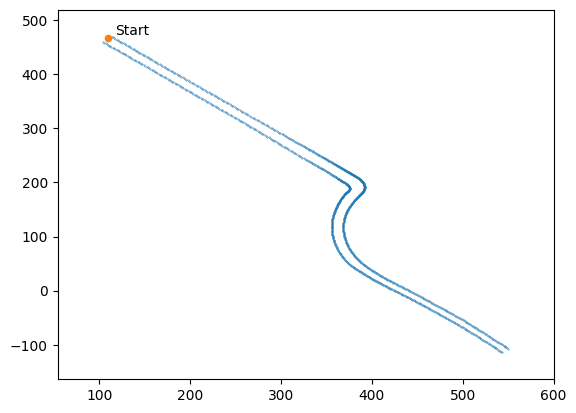

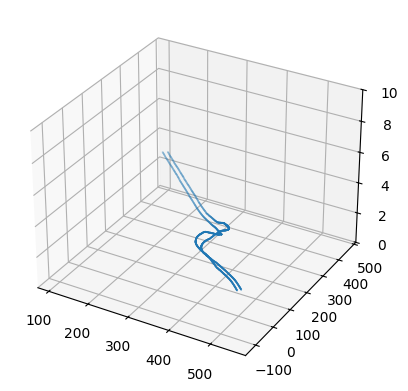

In [9]:
plot_track_2d(track)
plot_track_3d(track)

Started using SQL queries to find the braking points of each lap

In [10]:
# import pandasql as ps
import sqlite3 as sq



In [11]:
conn = sq.connect(':memory:')

In [12]:
race_data23.to_sql('race_data23', conn, index=False, if_exists='replace')

149470

In [13]:
# Checking the number of unique laps, and unique sessions (when braking > 0 unique laps drops to 510)
q = """SELECT count(*) as unique_laps, count(distinct session_identifier) as unique_sessions
    FROM 
        (select distinct session_identifier, lap_num
        from race_data23 
        )"""
result = pd.read_sql_query(q, conn)
print(result)

   unique_laps  unique_sessions
0          517              188


In [14]:
# Took the relevant variables for each braking point (idk how they brake and throttle at the same time?)
bp_query = """Select session_identifier, lap_num, min(frame), brake, throttle, lap_distance, worldposx, worldposy, worldposz
    from race_data23
    where brake > 0
    Group by session_identifier, lap_num
    order by session_identifier, lap_num asc"""
braking_points = pd.read_sql_query(bp_query, conn)
print(braking_points)

     SESSION_IDENTIFIER  LAP_NUM  min(frame)     BRAKE  THROTTLE  \
0          9.718583e+16        1        1058  0.059342  0.993271   
1          9.718583e+16        2        2957  0.064454  1.000000   
2          9.718583e+16        3        4623  0.067002  1.000000   
3          1.221455e+17        1        1428  0.000961  1.000000   
4          1.221455e+17        2        5838  0.004990  0.000000   
..                  ...      ...         ...       ...       ...   
505        1.796284e+19        1         969  0.074556  0.943297   
506        1.796284e+19        2        2624  0.077119  1.000000   
507        1.796284e+19        3        4310  0.139574  0.676478   
508        1.834959e+19        1        3375  0.628161  0.333333   
509        1.834959e+19        2        5910  0.638468  0.333333   

     LAP_DISTANCE   WORLDPOSX   WORLDPOSY  WORLDPOSZ  
0      242.434555  287.708221  299.659302   1.728924  
1      263.081055  302.297943  285.049988   1.765498  
2      265.865234 

In [15]:
brakepoint_2 = """Select session_identifier, lap_num, (frame), brake, throttle, lap_distance, worldposx, worldposy, worldposz
    from race_data23
    where brake > throttle
    Group by session_identifier, lap_num
    order by session_identifier, lap_num asc"""

result = pd.read_sql_query(brakepoint_2, conn)
# changing display widths
pd.set_option('display.max_colwidth', None)  # No limit on column width
pd.set_option('display.max_columns', None)   # Display all columns
pd.set_option('display.width', 1000)
print(result)

     SESSION_IDENTIFIER  LAP_NUM  FRAME     BRAKE  THROTTLE  LAP_DISTANCE   WORLDPOSX   WORLDPOSY  WORLDPOSZ
0          9.718583e+16        1   1061  0.290349  0.193057    256.216125  297.680695  290.156464   1.737152
1          9.718583e+16        2   2959  0.692393  0.317281    272.282227  308.920135  278.658142   1.791387
2          9.718583e+16        3   4624  0.685805  0.297515    270.492188  307.780426  280.056488   1.782596
3          1.221455e+17        1   1478  0.098054  0.000000    289.419220  320.363892  265.828552   1.869265
4          1.221455e+17        2   5838  0.004990  0.000000    243.404297  287.502045  298.047760   1.763520
..                  ...      ...    ...       ...       ...           ...         ...         ...        ...
503        1.796284e+19        1    972  0.541100  0.165087    264.014130  303.435394  284.886841   1.752592
504        1.796284e+19        2   2626  0.738674  0.296269    258.041016  298.740814  288.624847   1.748823
505        1.796284

In [16]:
avg_bp1 = """Select avg(lap_distance), avg(worldposx), avg(worldposy), avg(worldposz)
    from (
        Select session_identifier, lap_num, min(frame), brake, throttle, lap_distance, worldposx, worldposy, worldposz
        from race_data23
        where brake > 0
        Group by session_identifier, lap_num
        order by session_identifier, lap_num asc
    )"""
avg_bp2 = """Select avg(lap_distance), avg(worldposx), avg(worldposy), avg(worldposz)
    from (
        Select session_identifier, lap_num, min(frame), brake, throttle, lap_distance, worldposx, worldposy, worldposz
        from race_data23
        where brake > throttle
        Group by session_identifier, lap_num
        order by session_identifier, lap_num asc
    )"""
avg_bp3 = """Select avg(lap_distance), avg(worldposx), avg(worldposy), avg(worldposz)
    from (
        Select session_identifier, lap_num, min(frame), brake, throttle, lap_distance, worldposx, worldposy, worldposz
        from race_data23
        where brake > 0 and throttle == 0
        Group by session_identifier, lap_num
        order by session_identifier, lap_num asc
    )"""
print(f"brake points when brake > 0\n")
bp_1 = pd.read_sql_query(avg_bp1, conn)
print(bp_1)
print(f"\n\nbrake points when brake > throttle\n")
bp_2 = pd.read_sql_query(avg_bp2, conn)
print(bp_2)
print(f"\n\nbrake points when brake > 0, throttle = 0\n")
bp_3 = pd.read_sql_query(avg_bp3, conn)
print(bp_3)

brake points when brake > 0

   avg(lap_distance)  avg(worldposx)  avg(worldposy)  avg(worldposz)
0         233.834919      280.095134      304.575197        1.892893


brake points when brake > throttle

   avg(lap_distance)  avg(worldposx)  avg(worldposy)  avg(worldposz)
0         258.987326      298.349575      287.208398        1.823247


brake points when brake > 0, throttle = 0

   avg(lap_distance)  avg(worldposx)  avg(worldposy)  avg(worldposz)
0         265.274772      302.895117      282.835864        1.840727


In [17]:
brakepoint_3 = """Select session_identifier, lap_num, min(frame), brake, throttle, lap_distance, worldposx, worldposy, worldposz
        from race_data23
        where brake > 0 and throttle == 0
        Group by session_identifier, lap_num
        order by session_identifier, lap_num asc"""

result1 = pd.read_sql_query(brakepoint_3, conn)
# changing display widths
pd.set_option('display.max_colwidth', None)  # No limit on column width
pd.set_option('display.max_columns', None)   # Display all columns
pd.set_option('display.width', 1000)
print(result1)

     SESSION_IDENTIFIER  LAP_NUM  min(frame)     BRAKE  THROTTLE  LAP_DISTANCE   WORLDPOSX   WORLDPOSY  WORLDPOSZ
0          9.718583e+16        1        1063  0.428199       0.0    265.214447  304.165222  283.913361   1.762155
1          9.718583e+16        2        2960  0.947662       0.0    276.787109  312.163757  275.529938   1.805203
2          9.718583e+16        3        4628  1.000000       0.0    288.225586  320.550354  267.742401   1.838880
3          1.221455e+17        1        1478  0.098054       0.0    289.419220  320.363892  265.828552   1.869265
4          1.221455e+17        2        5838  0.004990       0.0    243.404297  287.502045  298.047760   1.763520
..                  ...      ...         ...       ...       ...           ...         ...         ...        ...
493        1.796284e+19        1         974  0.852125       0.0    272.891510  309.830536  278.725098   1.781191
494        1.796284e+19        2        2627  0.988525       0.0    262.555664  302.0107

I realised I messed up my logic for the queries, but this new query checks when there is no throttle and some braking

In [18]:
q = """
    SELECT distinct rd.session_identifier, rd.lap_num, rd.frame, rd.brake, rd.throttle, rd.lap_distance, rd.worldposx, rd.worldposy, rd.worldposz
    FROM race_data23 rd
    INNER JOIN (
        SELECT session_identifier, lap_num, MIN(frame) AS min_frame
        FROM race_data23
        WHERE brake > 0 AND throttle = 0
        GROUP BY session_identifier, lap_num
    ) subquery
    ON rd.session_identifier = subquery.session_identifier 
    AND rd.lap_num = subquery.lap_num
    AND rd.frame = subquery.min_frame
    ORDER BY rd.session_identifier, rd.lap_num ASC;
"""
new_bp = pd.read_sql_query(q, conn)
print(new_bp)

     SESSION_IDENTIFIER  LAP_NUM  FRAME     BRAKE  THROTTLE  LAP_DISTANCE   WORLDPOSX   WORLDPOSY  WORLDPOSZ
0          9.718583e+16        1   1063  0.428199       0.0    265.214447  304.165222  283.913361   1.762155
1          9.718583e+16        2   2960  0.947662       0.0    276.787109  312.163757  275.529938   1.805203
2          9.718583e+16        3   4628  1.000000       0.0    288.225586  320.550354  267.742401   1.838880
3          1.221455e+17        1   1478  0.098054       0.0    289.419220  320.363892  265.828552   1.869265
4          1.221455e+17        2   5838  0.004990       0.0    243.404297  287.502045  298.047760   1.763520
..                  ...      ...    ...       ...       ...           ...         ...         ...        ...
493        1.796284e+19        1    974  0.852125       0.0    272.891510  309.830536  278.725098   1.781191
494        1.796284e+19        2   2627  0.988525       0.0    262.555664  302.010742  285.510132   1.759877
495        1.796284

In [19]:
# wanted to check if my logic was wrong before
comparison = result1.equals(new_bp)
print("Are the queries equivalent?", comparison)


Are the queries equivalent? False


In [20]:
q = """
    SELECT count(*) as unique_laps, count(distinct session_identifier) as unique_sessions
    FROM 
        (select distinct session_identifier, lap_num
        from race_data23 
        where brake > 0 AND throttle = 0
    )"""
new_bp = pd.read_sql_query(q, conn)
print(new_bp)

   unique_laps  unique_sessions
0          498              183


In [21]:
# Updated braking_points file
# new_bp.to_csv('braking_points.csv', index=False)

In [22]:
import numpy as np

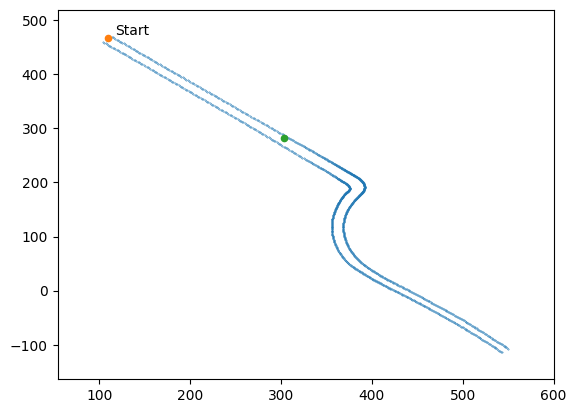

In [23]:
plot_track_2d(track)
bp_avg = pd.DataFrame(
        columns=['bp_x','bp_y','bp_z'],
        data=np.array([[302.895117,  282.835864,  1.840727]])
    )
plt.scatter(data=bp_avg, x='bp_x', y='bp_y', s=20)

In [24]:
avg_bp1 = """SELECT 
    AVG(rd.lap_distance) AS avg_lap_distance,
    AVG(rd.worldposx) AS avg_worldposx,
    AVG(rd.worldposy) AS avg_worldposy,
    AVG(rd.worldposz) AS avg_worldposz
FROM race_data23 rd
INNER JOIN (
    SELECT session_identifier, lap_num, MIN(frame) AS min_frame
    FROM race_data23
    WHERE brake > 0  -- Brake is greater than 0
    GROUP BY session_identifier, lap_num
) subquery
ON rd.session_identifier = subquery.session_identifier 
AND rd.lap_num = subquery.lap_num
AND rd.frame = subquery.min_frame;
    """
avg_bp2 = """SELECT 
    AVG(rd.lap_distance) AS avg_lap_distance,
    AVG(rd.worldposx) AS avg_worldposx,
    AVG(rd.worldposy) AS avg_worldposy,
    AVG(rd.worldposz) AS avg_worldposz
FROM race_data23 rd
INNER JOIN (
    SELECT session_identifier, lap_num, MIN(frame) AS min_frame
    FROM race_data23
    WHERE brake > throttle  -- Brake is greater than Throttle
    GROUP BY session_identifier, lap_num
) subquery
ON rd.session_identifier = subquery.session_identifier 
AND rd.lap_num = subquery.lap_num
AND rd.frame = subquery.min_frame;
    """
avg_bp3 = """SELECT 
    AVG(rd.lap_distance) AS avg_lap_distance,
    AVG(rd.worldposx) AS avg_worldposx,
    AVG(rd.worldposy) AS avg_worldposy,
    AVG(rd.worldposz) AS avg_worldposz
FROM race_data23 rd
INNER JOIN (
    SELECT session_identifier, lap_num, MIN(frame) AS min_frame
    FROM race_data23
    WHERE brake > 0 AND throttle = 0
    GROUP BY session_identifier, lap_num
) subquery
ON rd.session_identifier = subquery.session_identifier 
AND rd.lap_num = subquery.lap_num
AND rd.frame = subquery.min_frame;
"""
avg_bp4 = """SELECT 
    AVG(rd.lap_distance) AS avg_lap_distance,
    AVG(rd.worldposx) AS avg_worldposx,
    AVG(rd.worldposy) AS avg_worldposy,
    AVG(rd.worldposz) AS avg_worldposz
FROM race_data23 rd
INNER JOIN (
    SELECT session_identifier, lap_num, MIN(frame) AS min_frame
    FROM race_data23
    WHERE brake = 1 AND throttle = 0
    GROUP BY session_identifier, lap_num
) subquery
ON rd.session_identifier = subquery.session_identifier 
AND rd.lap_num = subquery.lap_num
AND rd.frame = subquery.min_frame;
"""
print(f"brake points when brake > 0\n")
bp_1 = pd.read_sql_query(avg_bp1, conn)
print(bp_1)
print(f"\n\nbrake points when brake > throttle\n")
bp_2 = pd.read_sql_query(avg_bp2, conn)
print(bp_2)
print(f"\n\nbrake points when brake > 0, throttle = 0\n")
bp_3 = pd.read_sql_query(avg_bp3, conn)
print(bp_3)
print(f"\n\nbrake points when brake = 0, throttle = 0\n")
bp_4 = pd.read_sql_query(avg_bp4, conn)
print(bp_4)

brake points when brake > 0

   avg_lap_distance  avg_worldposx  avg_worldposy  avg_worldposz
0        232.994336     279.491982     305.158688       1.896463


brake points when brake > throttle

   avg_lap_distance  avg_worldposx  avg_worldposy  avg_worldposz
0        258.908719     298.296764     287.265394       1.822971


brake points when brake > 0, throttle = 0

   avg_lap_distance  avg_worldposx  avg_worldposy  avg_worldposz
0        265.187174     302.835865     282.899235        1.84037


brake points when brake = 0, throttle = 0

   avg_lap_distance  avg_worldposx  avg_worldposy  avg_worldposz
0        292.579153     321.518102     263.774051       1.886508


### A plot of the average braking points using different definitions of a braking point

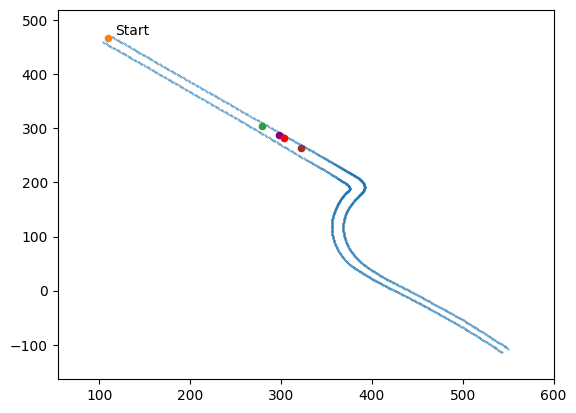

In [25]:
plot_track_2d(track)
bp1_avg = pd.DataFrame( # brake > 0
        columns=['bp_x','bp_y','bp_z'],
        data=np.array([[279.491982,     305.158688,       1.896463]])
    )
bp2_avg = pd.DataFrame( # brake > throttle
        columns=['bp_x','bp_y','bp_z'],
        data=np.array([[298.296764   ,  287.265394    ,   1.822971]])
    )
bp3_avg = pd.DataFrame( # brake > 0 and throttle = 0
        columns=['bp_x','bp_y','bp_z'],
        data=np.array([[ 302.835865  ,   282.899235    ,    1.84037]])
    )
bp4_avg = pd.DataFrame( # brake > 0 and throttle = 0
        columns=['bp_x','bp_y','bp_z'],
        data=np.array([[321.518102  ,   263.774051   ,    1.886508]])
    )
plt.scatter(data=bp1_avg, x='bp_x', y='bp_y', s=20)
plt.scatter(data=bp2_avg, x='bp_x', y='bp_y', s=20, color = 'purple')
plt.scatter(data=bp3_avg, x='bp_x', y='bp_y', s=20, color = 'red')
plt.scatter(data=bp4_avg, x='bp_x', y='bp_y', s=20, color = 'brown')

# Green -> brake > 0
# Purple -> brake > throttle
# Red -> brake > 0 AND throttle = 0
# Brown -> brake = 1 AND throttle = 0

Started looking at turning points

In [26]:
turning = """
    SELECT distinct rd.session_identifier, rd.lap_num, rd.frame, rd.brake, rd.throttle, rd.steering, rd.lap_distance, rd.worldposx, rd.worldposy, rd.worldposz
    FROM race_data23 rd
    INNER JOIN (
        SELECT session_identifier, lap_num, MIN(frame) AS min_frame
        FROM race_data23
        WHERE abs(steering) > 0.1
        GROUP BY session_identifier, lap_num
    ) subquery
    ON rd.session_identifier = subquery.session_identifier 
    AND rd.lap_num = subquery.lap_num
    AND rd.frame = subquery.min_frame
    ORDER BY rd.session_identifier, rd.lap_num ASC;
"""


turning_point = pd.read_sql_query(turning, conn)
print(turning_point)

     SESSION_IDENTIFIER  LAP_NUM  FRAME     BRAKE  THROTTLE  STEERING  LAP_DISTANCE   WORLDPOSX   WORLDPOSY  WORLDPOSZ
0          9.718583e+16        1   1084  1.000000       0.0  0.172488    339.766846  357.337280  231.613037   2.217618
1          9.718583e+16        2   2973  1.000000       0.0  0.146853    326.379883  347.883392  241.103485   2.084690
2          9.718583e+16        3   4640  1.000000       0.0  0.160141    332.125000  351.929596  237.020645   2.141748
3          1.221455e+17        1   1492  0.150057       0.0  0.102770    349.416748  363.669983  224.265076   2.257025
4          1.221455e+17        2   5860  0.258137       0.0  0.107164    325.111816  347.246552  242.269226   2.068161
..                  ...      ...    ...       ...       ...       ...           ...         ...         ...        ...
511        1.796284e+19        1    990  1.000000       0.0  0.161920    330.279510  350.874298  238.584763   2.129713
512        1.796284e+19        2   2647  1.00000

In [27]:
avg_turing1 = """SELECT 
    AVG(rd.lap_distance) AS avg_lap_distance,
    AVG(rd.worldposx) AS avg_worldposx,
    AVG(rd.worldposy) AS avg_worldposy,
    AVG(rd.worldposz) AS avg_worldposz
FROM race_data23 rd
INNER JOIN (
    SELECT session_identifier, lap_num, MIN(frame) AS min_frame
    FROM race_data23
    WHERE abs(steering) > 0.1  -- steering is greater than 0
    GROUP BY session_identifier, lap_num
) subquery
ON rd.session_identifier = subquery.session_identifier 
AND rd.lap_num = subquery.lap_num
AND rd.frame = subquery.min_frame;
    """
print(f"average turning point when |steering| > 0.1 \n")
turn1 = pd.read_sql_query(avg_turing1, conn)
print(turn1)
avg_turing2 = """SELECT 
    AVG(rd.lap_distance) AS avg_lap_distance,
    AVG(rd.worldposx) AS avg_worldposx,
    AVG(rd.worldposy) AS avg_worldposy,
    AVG(rd.worldposz) AS avg_worldposz
FROM race_data23 rd
INNER JOIN (
    SELECT session_identifier, lap_num, MIN(frame) AS min_frame
    FROM race_data23
    WHERE abs(steering) > 0.2  -- steering is greater than 0
    GROUP BY session_identifier, lap_num
) subquery
ON rd.session_identifier = subquery.session_identifier 
AND rd.lap_num = subquery.lap_num
AND rd.frame = subquery.min_frame;
    """
print(f"\n\naverage turning point when |steering| > 0.1 \n")
turn2 = pd.read_sql_query(avg_turing2, conn)
print(turn2)
avg_turing3 = """SELECT 
    AVG(rd.lap_distance) AS avg_lap_distance,
    AVG(rd.worldposx) AS avg_worldposx,
    AVG(rd.worldposy) AS avg_worldposy,
    AVG(rd.worldposz) AS avg_worldposz
FROM race_data23 rd
INNER JOIN (
    SELECT session_identifier, lap_num, MIN(frame) AS min_frame
    FROM race_data23
    WHERE abs(steering) > 0.3  -- steering is greater than 0
    GROUP BY session_identifier, lap_num
) subquery
ON rd.session_identifier = subquery.session_identifier 
AND rd.lap_num = subquery.lap_num
AND rd.frame = subquery.min_frame;
    """
print(f"average turning point when |steering| > 0.3 \n")
turn3 = pd.read_sql_query(avg_turing3, conn)
print(turn3)

average turning point when |steering| > 0.1 

   avg_lap_distance  avg_worldposx  avg_worldposy  avg_worldposz
0         328.98741     348.687413     238.273403       2.135384


average turning point when |steering| > 0.1 

   avg_lap_distance  avg_worldposx  avg_worldposy  avg_worldposz
0        347.344073     360.036313     224.230539        2.18772
average turning point when |steering| > 0.3 

   avg_lap_distance  avg_worldposx  avg_worldposy  avg_worldposz
0        356.894571     365.311115       216.5373       2.197558


A plot of turning and braking points

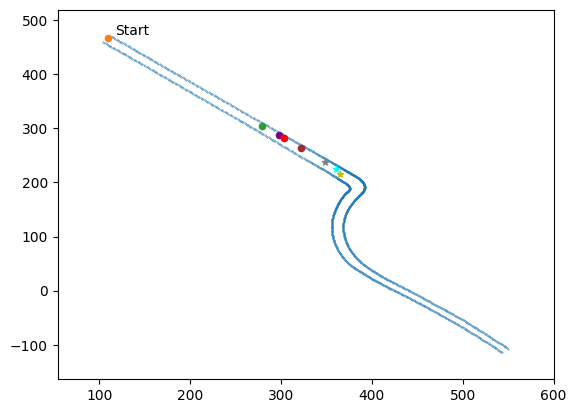

In [28]:
plot_track_2d(track)
bp1_avg = pd.DataFrame( # brake > 0
        columns=['bp_x','bp_y','bp_z'],
        data=np.array([[279.491982,     305.158688,       1.896463]])
    )
bp2_avg = pd.DataFrame( # brake > throttle
        columns=['bp_x','bp_y','bp_z'],
        data=np.array([[298.296764   ,  287.265394    ,   1.822971]])
    )
bp3_avg = pd.DataFrame( # brake > 0 and throttle = 0
        columns=['bp_x','bp_y','bp_z'],
        data=np.array([[ 302.835865  ,   282.899235    ,    1.84037]])
    )
bp4_avg = pd.DataFrame( # brake > 0 and throttle = 0
        columns=['bp_x','bp_y','bp_z'],
        data=np.array([[321.518102  ,   263.774051   ,    1.886508]])
    )
plt.scatter(data=bp1_avg, x='bp_x', y='bp_y', s=20)
plt.scatter(data=bp2_avg, x='bp_x', y='bp_y', s=20, color = 'purple')
plt.scatter(data=bp3_avg, x='bp_x', y='bp_y', s=20, color = 'red')
plt.scatter(data=bp4_avg, x='bp_x', y='bp_y', s=20, color = 'brown')

turning_avg = pd.DataFrame( # brake > 0 and throttle = 0
        columns=['turn_x','turn_y','turn_z'],
        data=np.array([[ 348.687413  ,  238.273403    ,   2.135384]])
    )
plt.scatter(data=turning_avg, x='turn_x', y='turn_y', s=20, color = 'gray', marker='*')
turning_avg2 = pd.DataFrame( # brake > 0 and throttle = 0
        columns=['turn_x','turn_y','turn_z'],
        data=np.array([[ 360.036313   ,  224.230539   ,    2.18772]])
    )
plt.scatter(data=turning_avg2, x='turn_x', y='turn_y', s=20, color = 'cyan', marker='*')
turning_avg3 = pd.DataFrame( # brake > 0 and throttle = 0
        columns=['turn_x','turn_y','turn_z'],
        data=np.array([[ 365.311115     ,  216.5373  ,     2.197558]])
    )
plt.scatter(data=turning_avg3, x='turn_x', y='turn_y', s=20, color = 'y', marker='*')

# Green -> brake > 0
# Purple -> brake > throttle
# Red -> brake > 0 AND throttle = 0
# Brown -> brake = 1 AND throttle = 0
# Black star -> |steering| > 0.1

In [29]:
# import pandas as pd
# import numpy as np

# Load the CSV file into a DataFrame
# df = pd.read_csv('steering_data.csv')  # Replace 'steering_data.csv' with your actual file name
df = race_data23

# Sort by session_identifier, lap_num, and frame (assuming frame represents time or sequence)
df = df.sort_values(by=['SESSION_IDENTIFIER', 'LAP_NUM', 'FRAME'])

# Define a function to find the first local maxima for each lap
def find_first_maxima(group):
    # Use shift() to compare the current steering value with previous and next values
    group['IS_LOCAL_MAXIMA'] = (group['STEERING'] > group['STEERING'].shift(1)) & (group['STEERING'] > group['STEERING'].shift(-1))
    
    # Filter for local maxima
    local_maxima = group[group['IS_LOCAL_MAXIMA']]
    
    # Find the first local maxima if it exists
    if not local_maxima.empty:
        return local_maxima.iloc[0]
    else:
        return pd.Series()  # Return empty if no local maxima found

# Apply the function to each group of session_identifier and lap_num
first_maxima_per_lap = df.groupby(['SESSION_IDENTIFIER', 'LAP_NUM']).apply(find_first_maxima).reset_index(drop=True)

# Drop the helper column 'is_local_maxima'
first_maxima_per_lap.drop(columns='IS_LOCAL_MAXIMA', inplace=True)

# Display the first local maxima for each lap
print(first_maxima_per_lap)

0        97185831637688192.0
1                       1011
2                          1
3                          0
4                  31.082165
                ...         
14930               -24212.0
14931                24213.0
14932                 -164.0
14933               -22075.0
14934                   True
Length: 14935, dtype: object


/var/folders/1z/8gdr4m5s3vnglmy5m5q4vrzh0000gn/T/ipykernel_16044/1277733338.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  first_maxima_per_lap = df.groupby(['SESSION_IDENTIFIER', 'LAP_NUM']).apply(find_first_maxima).reset_index(drop=True)


For turning: look at the rate of turning.
For braking: look at speed -> when its decelerating
For accleration: look at the speed again
 - Maybe a first throttle input, max throttle input
Could be worth looking at the 

apex 

In [30]:
# Assuming df is your DataFrame
# Sort by session_identifier, lap_num, and frame in ascending order
df = race_data23
df = df.sort_values(by=['SESSION_IDENTIFIER', 'LAP_NUM', 'FRAME'])

# Create columns for previous and next STEERING values
df['STEERING_PREV'] = df['STEERING'].shift(1)  # Previous steering value
df['STEERING_NEXT'] = df['STEERING'].shift(-1) # Next steering value

# Now you can compare the current row with the previous and next rows
df['IS_GREATER_THAN_PREV'] = df['STEERING'] > df['STEERING_PREV']
df['IS_GREATER_THAN_NEXT'] = df['STEERING'] > df['STEERING_NEXT']

# For example, you can create a column to check if the current value is a local maximum:
df['IS_LOCAL_MAXIMA'] = (df['IS_GREATER_THAN_PREV']) & (df['IS_GREATER_THAN_NEXT'])

df_max_steer = df[df['IS_LOCAL_MAXIMA'] == True]

# Display the relevant columns
print(df_max_steer[['SESSION_IDENTIFIER', 'LAP_NUM', 'FRAME', 'STEERING', 'STEERING_PREV', 'STEERING_NEXT', 'IS_LOCAL_MAXIMA', 'WORLDPOSX', 'WORLDPOSY', 'WORLDPOSZ']])


         SESSION_IDENTIFIER  LAP_NUM  FRAME  STEERING  STEERING_PREV  STEERING_NEXT  IS_LOCAL_MAXIMA   WORLDPOSX   WORLDPOSY  WORLDPOSZ
1115657        9.718583e+16        1   1011  0.000052      -0.000680      -0.000052             True  134.680878  445.344666   2.740732
1115663        9.718583e+16        1   1017  0.001413       0.000994       0.001308             True  153.654999  427.267365   2.602739
1115671        9.718583e+16        1   1025  0.004865       0.004761       0.004761             True  179.222549  402.869446   2.434766
1115684        9.718583e+16        1   1038  0.001517       0.001413      -0.002040             True  221.329880  362.560181   2.123459
1115689        9.718583e+16        1   1043  0.010620       0.009783       0.006121             True  237.829544  346.995819   2.016642
...                     ...      ...    ...       ...            ...            ...              ...         ...         ...        ...
623894         1.834959e+19        2   6066  0.2

In [31]:
pd.set_option('display.float_format', '{:.0f}'.format)
df = race_data23
# df.head()
filtered_df = df[df['SESSION_IDENTIFIER'] == '10034676866664400896']
filtered_df.head()

,SESSION_IDENTIFIER,FRAME,LAP_NUM,SECTOR,LAP_DISTANCE,CURRENT_LAP_TIME_MS,SECTOR_1_TIME_MS,SECTOR_2_TIME_MS,LAP_TIME_MS,SECTOR_3_MS,SPEED_KPH,THROTTLE,BRAKE,GEAR,ENGINE_RPM,STEERING,YAW,PITCH,ROLL,WORLDPOSX,WORLDPOSY,WORLDPOSZ,WORLDFORWARDDIRX,WORLDFORWARDDIRY,WORLDFORWARDDIRZ,WORLDRIGHTDIRX,WORLDRIGHTDIRY,WORLDRIGHTDIRZ


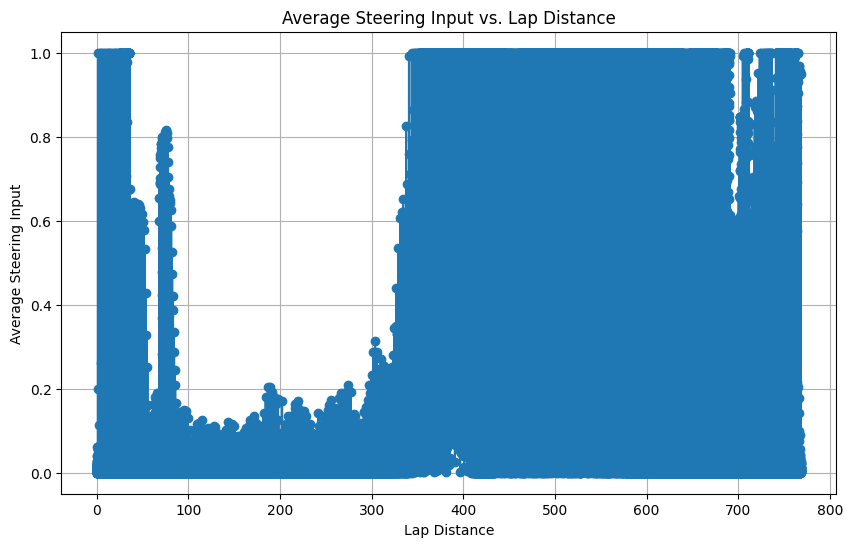

In [32]:
# Sort the DataFrame by session_identifier, lap_num, and frame
df = race_data23
# df_sorted = df.sort_values(by=['SESSION_IDENTIFIER', 'LAP_NUM', 'FRAME'])
# Assuming df is your DataFrame, already loaded and cleaned

# Sort the DataFrame by session_identifier, lap_num, and lap_distance
avg_steering_by_distance = df.groupby('LAP_DISTANCE')['STEERING'].mean().reset_index()

# Plot the average steering against lap_distance
plt.figure(figsize=(10, 6))
x = abs(avg_steering_by_distance['STEERING'])
plt.plot(avg_steering_by_distance['LAP_DISTANCE'], x, marker='o', linestyle='-')

# Add plot labels and title
plt.xlabel('Lap Distance')
plt.ylabel('Average Steering Input')
plt.title('Average Steering Input vs. Lap Distance')

# Show the plot
plt.grid(True)
plt.show()



In [33]:
# import pandas as pd

# Load the data
# df = pd.read_csv('your_file_path.csv')
df = race_data23

# Function to find the first maxima in 'STEERING'
def find_first_steering_maxima(df):
    results = []
    grouped = df.groupby(['SESSION_IDENTIFIER', 'LAP_NUM'])
    
    for (session, lap), group in grouped:
        group = group.sort_values('FRAME')  # Sort by time/frame
        # Calculate the difference to detect when STEERING values change direction
        steering_diff = group['STEERING'].diff()
        # Find the first point where the diff goes from positive to negative (indicating a peak)
        maxima = (steering_diff.shift(-1) < 0) & (steering_diff > 0)
        first_maxima = group[maxima].head(1)
        if not first_maxima.empty:
            results.append(first_maxima)
    # return group[maxima]
    return pd.concat(results) if results else pd.DataFrame()

# Function to find the first point where the car starts decelerating
def find_first_deceleration(df):
    results = []
    grouped = df.groupby(['SESSION_IDENTIFIER', 'LAP_NUM'])
    
    for (session, lap), group in grouped:
        group = group.sort_values('FRAME')  # Sort by time/frame
        # Calculate the speed difference to find where it decreases
        speed_diff = group['SPEED_KPH'].diff()
        # Find the first point where speed decreases
        deceleration = speed_diff < 0
        first_deceleration = group[deceleration].head(1)
        if not first_deceleration.empty:
            results.append(first_deceleration)

    return pd.concat(results) if results else pd.DataFrame()

# Apply the functions
steering_maxima = find_first_steering_maxima(df)
first_deceleration = find_first_deceleration(df)




# Display results
print("First Steering Maxima:\n", steering_maxima)
print("First Deceleration Point:\n", first_deceleration)


First Steering Maxima:
           SESSION_IDENTIFIER  FRAME  LAP_NUM  SECTOR  LAP_DISTANCE  CURRENT_LAP_TIME_MS  SECTOR_1_TIME_MS  SECTOR_2_TIME_MS  LAP_TIME_MS  SECTOR_3_MS  SPEED_KPH  THROTTLE  BRAKE  GEAR  ENGINE_RPM  STEERING  YAW  PITCH  ROLL  WORLDPOSX  WORLDPOSY  WORLDPOSZ  WORLDFORWARDDIRX  WORLDFORWARDDIRY  WORLDFORWARDDIRZ  WORLDRIGHTDIRX  WORLDRIGHTDIRY  WORLDRIGHTDIRZ
1115657    97185831637688192   1011        1       0            31                  350             29793             18287        94549        46469        312         1      0     8       11178         0   -2      0    -0        135        445          3            -23715              -144            -22610           22599             910          -23709
1117545    97185831637688192   2903        2       0            21                  233             28837             18406        82927        35684        309         1      0     8       11068        -0   -2      0    -0        127        452          3  

In [34]:
q = """
    SELECT *
    from race_data23
    where round(SESSION_IDENTIFIER,0.1) = 122145520320873184;
"""

# """PRAGMA table_info(race_data23);
# """
query = pd.read_sql_query(q, conn)
print(query)

      SESSION_IDENTIFIER  FRAME  LAP_NUM  SECTOR  LAP_DISTANCE  CURRENT_LAP_TIME_MS  SECTOR_1_TIME_MS  SECTOR_2_TIME_MS  LAP_TIME_MS  SECTOR_3_MS  SPEED_KPH  THROTTLE  BRAKE  GEAR  ENGINE_RPM  STEERING  YAW  PITCH  ROLL  WORLDPOSX  WORLDPOSY  WORLDPOSZ  WORLDFORWARDDIRX  WORLDFORWARDDIRY  WORLDFORWARDDIRZ  WORLDRIGHTDIRX  WORLDRIGHTDIRY  WORLDRIGHTDIRZ
0     122145520320873184   1412        1       0             2                   16             52455             22833       218185       142897        293         1      0     8       10527         0   -2      0    -0        113        465          3            -23249              -135            -23089           23078             877          -23243
1     122145520320873184   1413        1       0             6                   66             52455             22833       218185       142897        294         1      0     8       10538        -0   -2      0    -0        116        462          3            -23204              -171  

In [35]:
# first_deceleration.to_csv('first_deceleration.csv', index=False)

In [36]:
first_deceleration.head()

,SESSION_IDENTIFIER,FRAME,LAP_NUM,SECTOR,LAP_DISTANCE,CURRENT_LAP_TIME_MS,SECTOR_1_TIME_MS,SECTOR_2_TIME_MS,LAP_TIME_MS,SECTOR_3_MS,SPEED_KPH,THROTTLE,BRAKE,GEAR,ENGINE_RPM,STEERING,YAW,PITCH,ROLL,WORLDPOSX,WORLDPOSY,WORLDPOSZ,WORLDFORWARDDIRX,WORLDFORWARDDIRY,WORLDFORWARDDIRZ,WORLDRIGHTDIRX,WORLDRIGHTDIRY,WORLDRIGHTDIRZ
1115706,97185831637688192,1060,1,0,252,2802,29793,18287,94549,46469,329,0,0,8,11582,0,-2,-0,-0,294,293,2,-23660,74,-22668,22662,837,-23651
1117600,97185831637688192,2958,2,0,268,2986,28837,18406,82927,35684,331,1,0,8,11725,-0,-2,-0,-0,306,282,2,-23571,123,-22761,22758,640,-23565
1119245,97185831637688192,4624,3,0,270,3002,28998,18086,83016,35932,331,0,1,8,11569,0,-2,-0,-0,308,280,2,-23600,121,-22730,22727,649,-23594
131629,122145520320873184,1477,1,0,285,3269,52455,22833,218185,142897,325,0,0,8,11414,-0,-2,-0,-0,317,269,2,-24374,113,-21898,21896,572,-24370
135906,122145520320873184,5828,2,0,199,2285,11061,25843,165517,128613,323,0,0,8,11422,0,-2,0,-0,255,328,2,-24072,-184,-22229,22220,778,-24068


In [37]:
# steering_maxima.to_csv('steering_maxima.csv', index=False)

In [38]:
# Function to find maximum steering within predefined coordinates
def find_max_steering_in_region(df, x_bounds, y_bounds):
    
    # Filter by X and Y coordinates
    within_x = (df['WORLDPOSX'] >= x_bounds[0]) & (df['WORLDPOSX'] <= x_bounds[1])
    within_y = (df['WORLDPOSY'] >= y_bounds[0]) & (df['WORLDPOSY'] <= y_bounds[1])
    
    filtered_df = df[within_x & within_y]

    grouped = filtered_df.groupby(['SESSION_IDENTIFIER', 'LAP_NUM'])
    
    results = []
    
    for (session, lap), group in grouped:
        # group = group.sort_values('FRAME')  # Sort by time/frame
        # Calculate the difference to detect when STEERING values change direction
        steering_max = group['STEERING'].max()

        # Append the result as a dictionary
        results.append({
            'SESSION_IDENTIFIER': session,
            'LAP_NUM': lap,
            'MAX_STEERING': steering_max
        })
    result_df = pd.DataFrame(results)

    return result_df
        # if not first_maxima.empty:
        #     results.append(first_maxima)
    # return group[maxima]
    # return pd.concat(results) if results else pd.DataFrame()


    
x_bounds = (315, 405)  # Replace with your X range
y_bounds = (145, 260)  # Replace with your Y range

df = race_data23

max_steering = find_max_steering_in_region(df, x_bounds, y_bounds)

print(max_steering)

      SESSION_IDENTIFIER  LAP_NUM  MAX_STEERING
0      97185831637688192        1             1
1      97185831637688192        2             1
2      97185831637688192        3             1
3     122145520320873184        1             1
4     122145520320873184        2             0
..                   ...      ...           ...
511 17962844060030703616        1             1
512 17962844060030703616        2             1
513 17962844060030703616        3             1
514 18349591879748417536        1             1
515 18349591879748417536        2             1

[516 rows x 3 columns]


In [39]:
# max_steering.to_csv('t1_max_steer.csv', index=False)

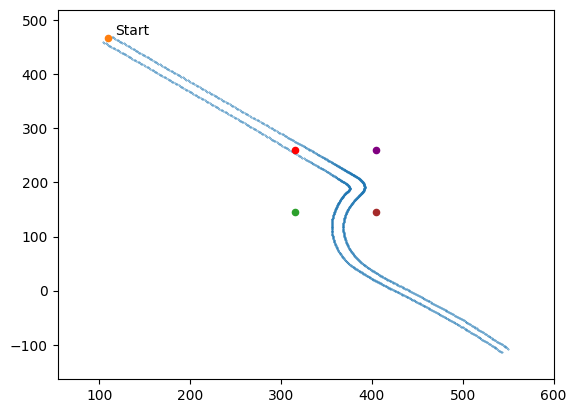

In [40]:
plot_track_2d(track)
bp1_avg = pd.DataFrame( # brake > 0
        columns=['bp_x','bp_y','bp_z'],
        data=np.array([[315,     145,       1.896463]])
    )
bp2_avg = pd.DataFrame( # brake > throttle
        columns=['bp_x','bp_y','bp_z'],
        data=np.array([[405   ,  260    ,   1.822971]])
    )
bp3_avg = pd.DataFrame( # brake > 0 and throttle = 0
        columns=['bp_x','bp_y','bp_z'],
        data=np.array([[ 315  ,   260    ,    1.84037]])
    )
bp4_avg = pd.DataFrame( # brake > 0 and throttle = 0
        columns=['bp_x','bp_y','bp_z'],
        data=np.array([[405  ,   145   ,    1.886508]])
    )
plt.scatter(data=bp1_avg, x='bp_x', y='bp_y', s=20)
plt.scatter(data=bp2_avg, x='bp_x', y='bp_y', s=20, color = 'purple')
plt.scatter(data=bp3_avg, x='bp_x', y='bp_y', s=20, color = 'red')
plt.scatter(data=bp4_avg, x='bp_x', y='bp_y', s=20, color = 'brown')

# turning_avg = pd.DataFrame( # brake > 0 and throttle = 0
#         columns=['turn_x','turn_y','turn_z'],
#         data=np.array([[ 348.687413  ,  238.273403    ,   2.135384]])
#     )
# plt.scatter(data=turning_avg, x='turn_x', y='turn_y', s=20, color = 'gray', marker='*')
# turning_avg2 = pd.DataFrame( # brake > 0 and throttle = 0
#         columns=['turn_x','turn_y','turn_z'],
#         data=np.array([[ 360.036313   ,  224.230539   ,    2.18772]])
#     )
# plt.scatter(data=turning_avg2, x='turn_x', y='turn_y', s=20, color = 'cyan', marker='*')
# turning_avg3 = pd.DataFrame( # brake > 0 and throttle = 0
#         columns=['turn_x','turn_y','turn_z'],
#         data=np.array([[ 365.311115     ,  216.5373  ,     2.197558]])
#     )
# plt.scatter(data=turning_avg3, x='turn_x', y='turn_y', s=20, color = 'y', marker='*')

In [41]:
within_x = (df['WORLDPOSX'] >= x_bounds[0]) & (df['WORLDPOSX'] <= x_bounds[1])
within_y = (df['WORLDPOSY'] >= y_bounds[0]) & (df['WORLDPOSY'] <= y_bounds[1])
    
filtered_df = df[within_x & within_y]
print(filtered_df)

          SESSION_IDENTIFIER  FRAME  LAP_NUM  SECTOR  LAP_DISTANCE  CURRENT_LAP_TIME_MS  SECTOR_1_TIME_MS  SECTOR_2_TIME_MS  LAP_TIME_MS  SECTOR_3_MS  SPEED_KPH  THROTTLE  BRAKE  GEAR  ENGINE_RPM  STEERING  YAW  PITCH  ROLL  WORLDPOSX  WORLDPOSY  WORLDPOSZ  WORLDFORWARDDIRX  WORLDFORWARDDIRY  WORLDFORWARDDIRZ  WORLDRIGHTDIRX  WORLDRIGHTDIRY  WORLDRIGHTDIRZ
70      10034676866664400896   1750        1       0           300                 3503             30129             18569        87226        38528        285         0      1     8        9866         0   -2     -0    -0        329        259          2            -23456               141            -22879           22877             609          -23450
71      10034676866664400896   1751        1       0           304                 3553             30129             18569        87226        38528        278         0      1     8        9618         0   -2     -0    -0        332        256          2            -23387        

In [42]:
df = pd.read_csv('first_deceleration.csv')
df.head()

,SESSION_IDENTIFIER,FRAME,LAP_NUM,SECTOR,LAP_DISTANCE,CURRENT_LAP_TIME_MS,SECTOR_1_TIME_MS,SECTOR_2_TIME_MS,LAP_TIME_MS,SECTOR_3_MS,SPEED_KPH,THROTTLE,BRAKE,GEAR,ENGINE_RPM,STEERING,YAW,PITCH,ROLL,WORLDPOSX,WORLDPOSY,WORLDPOSZ,WORLDFORWARDDIRX,WORLDFORWARDDIRY,WORLDFORWARDDIRZ,WORLDRIGHTDIRX,WORLDRIGHTDIRY,WORLDRIGHTDIRZ
0,97185831637688192,1060,1,0,252,2802,29793,18287,94549,46469,329,0,0,8,11582,0,-2,-0,-0,294,293,2,-23660,74,-22668,22662,837,-23651
1,97185831637688192,2958,2,0,268,2986,28837,18406,82927,35684,331,1,0,8,11725,-0,-2,-0,-0,306,282,2,-23571,123,-22761,22758,640,-23565
2,97185831637688192,4624,3,0,270,3002,28998,18086,83016,35932,331,0,1,8,11569,0,-2,-0,-0,308,280,2,-23600,121,-22730,22727,649,-23594
3,122145520320873184,1477,1,0,285,3269,52455,22833,218185,142897,325,0,0,8,11414,-0,-2,-0,-0,317,269,2,-24374,113,-21898,21896,572,-24370
4,122145520320873184,5828,2,0,199,2285,11061,25843,165517,128613,323,0,0,8,11422,0,-2,0,-0,255,328,2,-24072,-184,-22229,22220,778,-24068


In [43]:
pd.set_option('display.float_format', '{:.6f}'.format)
average_positions = df[['WORLDPOSX', 'WORLDPOSY', 'WORLDPOSZ']].mean()
print(average_positions)

WORLDPOSX   282.624310
WORLDPOSY   302.966762
WORLDPOSZ     1.857756
dtype: float64


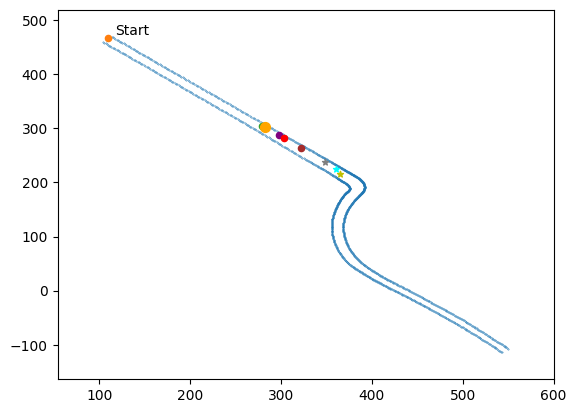

In [44]:
plot_track_2d(track)
bp1_avg = pd.DataFrame( # brake > 0
        columns=['bp_x','bp_y','bp_z'],
        data=np.array([[279.491982,     305.158688,       1.896463]])
    )
bp2_avg = pd.DataFrame( # brake > throttle
        columns=['bp_x','bp_y','bp_z'],
        data=np.array([[298.296764   ,  287.265394    ,   1.822971]])
    )
bp3_avg = pd.DataFrame( # brake > 0 and throttle = 0
        columns=['bp_x','bp_y','bp_z'],
        data=np.array([[ 302.835865  ,   282.899235    ,    1.84037]])
    )
bp4_avg = pd.DataFrame( # brake > 0 and throttle = 0
        columns=['bp_x','bp_y','bp_z'],
        data=np.array([[321.518102  ,   263.774051   ,    1.886508]])
    )
de5_avg = pd.DataFrame( # brake > 0 and throttle = 0
        columns=['bp_x','bp_y','bp_z'],
        data=np.array([[282.624310  ,   302.966762   ,    1.857756]])
    )
plt.scatter(data=bp1_avg, x='bp_x', y='bp_y', s=20)
plt.scatter(data=bp2_avg, x='bp_x', y='bp_y', s=20, color = 'purple')
plt.scatter(data=bp3_avg, x='bp_x', y='bp_y', s=20, color = 'red')
plt.scatter(data=bp4_avg, x='bp_x', y='bp_y', s=20, color = 'brown')
plt.scatter(data=de5_avg, x='bp_x', y='bp_y', s=50, color = 'orange')

turning_avg = pd.DataFrame( # brake > 0 and throttle = 0
        columns=['turn_x','turn_y','turn_z'],
        data=np.array([[ 348.687413  ,  238.273403    ,   2.135384]])
    )
plt.scatter(data=turning_avg, x='turn_x', y='turn_y', s=20, color = 'gray', marker='*')
turning_avg2 = pd.DataFrame( # brake > 0 and throttle = 0
        columns=['turn_x','turn_y','turn_z'],
        data=np.array([[ 360.036313   ,  224.230539   ,    2.18772]])
    )
plt.scatter(data=turning_avg2, x='turn_x', y='turn_y', s=20, color = 'cyan', marker='*')
turning_avg3 = pd.DataFrame( # brake > 0 and throttle = 0
        columns=['turn_x','turn_y','turn_z'],
        data=np.array([[ 365.311115     ,  216.5373  ,     2.197558]])
    )
plt.scatter(data=turning_avg3, x='turn_x', y='turn_y', s=20, color = 'y', marker='*')

# Green -> brake > 0
# Purple -> brake > throttle
# Red -> brake > 0 AND throttle = 0
# Brown -> brake = 1 AND throttle = 0
# Black star -> |steering| > 0.1

In [45]:
print(race_data23.dtypes)

SESSION_IDENTIFIER     float64
FRAME                    int64
LAP_NUM                  int64
SECTOR                   int64
LAP_DISTANCE           float64
CURRENT_LAP_TIME_MS      int64
SECTOR_1_TIME_MS         int64
SECTOR_2_TIME_MS         int64
LAP_TIME_MS            float64
SECTOR_3_MS            float64
SPEED_KPH              float64
THROTTLE               float64
BRAKE                  float64
GEAR                   float64
ENGINE_RPM             float64
STEERING               float64
YAW                    float64
PITCH                  float64
ROLL                   float64
WORLDPOSX              float64
WORLDPOSY              float64
WORLDPOSZ              float64
WORLDFORWARDDIRX       float64
WORLDFORWARDDIRY       float64
WORLDFORWARDDIRZ       float64
WORLDRIGHTDIRX         float64
WORLDRIGHTDIRY         float64
WORLDRIGHTDIRZ         float64
dtype: object


Give a chain of looking -> if they brake here great take that, if not, check before and take that point, if they break here

OR

Take first brake point/deceleration, take first acceleration from the boundary.

In [46]:
df = race_data23
group = df.groupby(['SESSION_IDENTIFIER', 'LAP_NUM'])
hotlap = group.apply(lambda x: x.sort_values(by=['LAP_TIME_MS'], ascending=True))
# hotlap = hotlap.iloc[0]
hotlap.head()

/var/folders/1z/8gdr4m5s3vnglmy5m5q4vrzh0000gn/T/ipykernel_16044/3629965818.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hotlap = group.apply(lambda x: x.sort_values(by=['LAP_TIME_MS'], ascending=True))


SESSION_IDENTIFIER  FRAME  LAP_NUM  SECTOR  LAP_DISTANCE  CURRENT_LAP_TIME_MS  SECTOR_1_TIME_MS  SECTOR_2_TIME_MS  LAP_TIME_MS  SECTOR_3_MS  SPEED_KPH  THROTTLE    BRAKE     GEAR   ENGINE_RPM  STEERING       YAW     PITCH      ROLL  WORLDPOSX  WORLDPOSY  WORLDPOSZ  WORLDFORWARDDIRX  WORLDFORWARDDIRY  WORLDFORWARDDIRZ  WORLDRIGHTDIRX  WORLDRIGHTDIRY  WORLDRIGHTDIRZ
SESSION_IDENTIFIER       LAP_NUM                                                                                                                                                                                                                                                                                                                                                                                             
97185831637688192.000000 1       1115650 97185831637688192.000000   1004        1       0      0.873622                    0             29793             18287 94549.000000 46469.000000 308.000000  1.000000 0.000000 8.000000 11056.000000  0.000680 -2.333265  0.004165 -0.025656 112.813309 466.210297   2.892802     -23694.000000       -136.000000     -22632.000000    22622.000000      840.000000   -23689.000000
                                 1115797 97185831637688192.000000   1151        1       0    496.409149                 7340             29793             18287 94549.000000 46469.000000 170.000000  1.000000 0.000000 4.000000 10635.000000 -0.208586 -2.940892 -0.003549 -0.016455 371.309845  89.288811   2.440971      -6532.000000        116.000000     -32109.000000    32105.000000      539.000000    -6529.000000
                                 1115798 97185831637688192.000000   1152        1       0    498.887848                 7390             29793             18287 94549.000000 46469.000000 171.000000  1.000000 0.000000 4.000000 10940.000000 -0.207540 -2.914940 -0.002230 -0.018198 371.747467  86.949867   2.447442      -7363.000000         73.000000     -31928.000000    31923.000000      596.000000    -7360.000000
                                 1115799 97185831637688192.000000   1153        1       0    501.375336                 7440             29793             18287 94549.000000 46469.000000 172.000000  1.000000 0.000000 4.000000 10963.000000 -0.207017 -2.888011 -0.004424 -0.021346 372.245514  84.613060   2.454599      -8220.000000        144.000000     -31718.000000    31712.000000      699.000000    -8215.000000
                                 1115800 97185831637688192.000000   1154        1       0    503.872528                 7490             29793             18287 94549.000000 46469.000000 172.000000  1.000000 0.000000 4.000000 10721.000000 -0.204506 -2.861608 -0.005884 -0.021147 372.806793  82.281944   2.464813      -9054.000000        192.000000     -31490.000000    31485.000000      692.000000    -9048.000000

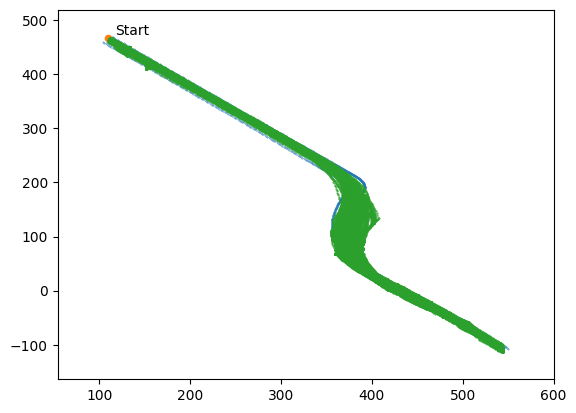

In [47]:
plot_track_2d(track)
hotlap_x = hotlap['WORLDPOSX']
hotlap_y = hotlap['WORLDPOSY']
plt.scatter(hotlap['WORLDPOSX'], hotlap['WORLDPOSY'], s=0.2)
# bp3_avg = pd.DataFrame( # brake > 0 and throttle = 0
#         columns=['hotlap_x','hotlap_y','bp_z'],
#         data=np.array([[ 789  ,   282.899235    ,    1.84037]])
# )
# plt.scatter(data=hotlap, x='bp_x', y='bp_y', s=20)

Write a function to find the angle to the apex from the forward vector, and the euclidean distance to apex.

In [48]:
# import math
# def vector_to_apex(df: pd.DataFrame, apex1: list, apex2: list):
#     # apex is a list 0 index is x coord, 1 is the y coord
#     df_new = df.copy()
#     required_columns = ['WORLDFORWARDDIRX', 'WORLDFORWARDDIRY', 'WORLDPOSX', 'WORLDPOSY']
#     if not all(col in df.columns for col in required_columns):
#         raise ValueError(f"DataFrame must contain the following columns: {required_columns}")
    
#     # df_new['forward_vector'] = list(map(tuple, (df_new['WORLDFORWARDDIRX'] , df_new['WORLDFORWARDDIRY'])))
#     df_new['forward_vector'] = list(zip(df_new['WORLDFORWARDDIRX'], df_new['WORLDFORWARDDIRY']))

#     df_new['world_pos'] = list(zip(df_new['WORLDPOSX'] , df_new['WORLDPOSY']))

#     # df_new['apex_vector'] = list(zip(apex - df_new['world_pos']))
#     df_new['apex_vector1'] = [(apex1[0] - pos[0], apex1[1] - pos[1]) for pos in df_new['world_pos']]
#     df_new['apex_vector2'] = [(apex2[0] - pos[0], apex2[1] - pos[1]) for pos in df_new['world_pos']]

#     # forward_vectors = np.array(df_new['forward_vector'])
#     # apex_vectors = np.array(df_new['apex_vector'])
    
#     def unit_vector(vector):
#         """ Returns the unit vector of the vector.  """
#         return vector / np.linalg.norm(vector)

#     def angle_between(v1, v2):
#         """ Returns the angle in radians between vectors 'v1' and 'v2'::

#             >>> angle_between((1, 0, 0), (0, 1, 0))
#             1.5707963267948966
#             >>> angle_between((1, 0, 0), (1, 0, 0))
#             0.0
#             >>> angle_between((1, 0, 0), (-1, 0, 0))
#             3.141592653589793
#         """
#         v1_u = unit_vector(v1)
#         v2_u = unit_vector(v2)
        
#         angle = np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

#         cross = v1_u[0] * v2_u[1] - v1_u[1] * v2_u[0]
        
#         # if cross < 0:
#         #     angle = -angle
    
#         return (angle * 180/math.pi)
    
#     df_new['angle_to_apex1'] = [angle_between(forward, apex1) for forward in df_new['forward_vector']]
#     df_new['angle_to_apex2'] = [angle_between(forward, apex2) for forward in df_new['forward_vector']]

#     df_new['dist_to_apex1'] = [euclid_distance(pos , apex1) for pos in df_new['world_pos']]
#     df_new['dist_to_apex2'] = [euclid_distance(pos , apex2) for pos in df_new['world_pos']]

#     return df_new

import math
import numpy as np
import pandas as pd

def vector_to_apex(df: pd.DataFrame, apex1: list, apex2: list):
    # apex is a list 0 index is x coord, 1 is the y coord

    df_new = df.copy()

    required_columns = ['WORLDFORWARDDIRX', 'WORLDFORWARDDIRY', 'WORLDPOSX', 'WORLDPOSY']
    
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"DataFrame must contain the following columns: {required_columns}")
    
    df_new['forward_vector'] = list(zip(df_new['WORLDFORWARDDIRX'], df_new['WORLDFORWARDDIRY']))
    df_new['world_pos'] = list(zip(df_new['WORLDPOSX'], df_new['WORLDPOSY']))

    df_new['apex_vector1'] = [(apex1[0] - pos[0], apex1[1] - pos[1]) for pos in df_new['world_pos']]
    df_new['apex_vector2'] = [(apex2[0] - pos[0], apex2[1] - pos[1]) for pos in df_new['world_pos']]

    def unit_vector(vector):
        """ Returns the unit vector of the vector.  """
        return vector / np.linalg.norm(vector)

    def angle_between(v1, v2):
        """ Returns the signed angle in degrees between vectors 'v1' and 'v2' clockwise. """
        v1_u = unit_vector(v1)
        v2_u = unit_vector(v2)
        
        # Compute the dot product and angle
        dot_product = np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)
        angle = np.arccos(dot_product)

        # Compute the cross product (determinant) in 2D to find the sign of the angle
        cross = v1_u[0] * v2_u[1] - v1_u[1] * v2_u[0]
        
        # If the cross product is negative, it means the angle is clockwise, so negate it
        if cross < 0:
            angle = -angle
        
        # Convert the angle from radians to degrees
        return np.degrees(angle)
    
    # Apply the angle function to calculate angles to both apexes
    df_new['angle_to_apex1'] = [angle_between(forward, apex) for forward, apex in zip(df_new['forward_vector'], df_new['apex_vector1'])]
    df_new['angle_to_apex2'] = [angle_between(forward, apex) for forward, apex in zip(df_new['forward_vector'], df_new['apex_vector2'])]

    # Euclidean distance function
    def euclid_distance(p1, p2):
        return np.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)

    # Calculate Euclidean distances to both apexes
    df_new['dist_to_apex1'] = [euclid_distance(pos, apex1) for pos in df_new['world_pos']]
    df_new['dist_to_apex2'] = [euclid_distance(pos, apex2) for pos in df_new['world_pos']]

    df_new = df_new.drop(['apex_vector1', 'apex_vector2', 'world_pos', 'forward_vector', 'dist_to_apex1', 'dist_to_apex2'], axis = 1)

    return df_new




In [49]:
apex1 = (375.57, 191.519)
apex2 = (368.93, 90)
df = race_data23
vectors = vector_to_apex(df, apex1, apex2)

In [50]:
vectors.head()

,SESSION_IDENTIFIER,FRAME,LAP_NUM,SECTOR,LAP_DISTANCE,CURRENT_LAP_TIME_MS,SECTOR_1_TIME_MS,SECTOR_2_TIME_MS,LAP_TIME_MS,SECTOR_3_MS,SPEED_KPH,THROTTLE,BRAKE,GEAR,ENGINE_RPM,STEERING,YAW,PITCH,ROLL,WORLDPOSX,WORLDPOSY,WORLDPOSZ,WORLDFORWARDDIRX,WORLDFORWARDDIRY,WORLDFORWARDDIRZ,WORLDRIGHTDIRX,WORLDRIGHTDIRY,WORLDRIGHTDIRZ,angle_to_apex1,angle_to_apex2
0,10034676866664400896.000000,1680,1,0,1.775714,16,30129,18569,87226.000000,38528.000000,294.000000,1.000000,0.030945,8.000000,10541.000000,-0.018082,-2.336760,0.004231,-0.025839,113.192245,465.303589,2.900799,-23615.000000,-138.000000,-22714.000000,22704.000000,846.000000,-23610.000000,133.446400,123.936313
1,10034676866664400896.000000,1681,1,0,5.864580,66,30129,18569,87226.000000,38528.000000,294.000000,1.000000,0.030945,8.000000,10547.000000,-0.018174,-2.333671,0.005806,-0.025955,116.142723,462.470612,2.874730,-23685.000000,-190.000000,-22641.000000,22630.000000,850.000000,-23681.000000,133.295631,123.704226
2,10034676866664400896.000000,1682,1,0,9.964501,116,30129,18569,87226.000000,38528.000000,295.000000,1.000000,0.031952,8.000000,10563.000000,-0.013687,-2.330126,0.005979,-0.024798,119.108170,459.637115,2.845881,-23765.000000,-195.000000,-22557.000000,22547.000000,812.000000,-23761.000000,133.256963,123.582948
3,10034676866664400896.000000,1683,1,0,14.072903,166,30129,18569,87226.000000,38528.000000,295.000000,1.000000,0.032959,8.000000,10581.000000,-0.000687,-2.327518,0.005315,-0.024717,122.087158,456.805298,2.821898,-23824.000000,-174.000000,-22495.000000,22485.000000,809.000000,-23820.000000,133.278129,123.520257
4,10034676866664400896.000000,1684,1,0,18.184681,216,30129,18569,87226.000000,38528.000000,296.000000,1.000000,0.032959,8.000000,10598.000000,0.004532,-2.326889,0.004296,-0.025042,125.073685,453.976288,2.798889,-23838.000000,-140.000000,-22480.000000,22471.000000,820.000000,-23833.000000,133.327735,123.484745


In [51]:
df = race_data23
# df['LAP_TIME_MS'].describe()
min_lap_time = df['LAP_TIME_MS'].min()
fast_lap = df[df['LAP_TIME_MS'] == min_lap_time]
fast_lap['SESSION_IDENTIFIER'].describe()

count                   218.000000
mean    4486621736790788608.000000
std                     513.178367
min     4486621736790789120.000000
25%     4486621736790789120.000000
50%     4486621736790789120.000000
75%     4486621736790789120.000000
max     4486621736790789120.000000
Name: SESSION_IDENTIFIER, dtype: float64

In [52]:
print(fast_lap)

               SESSION_IDENTIFIER  FRAME  LAP_NUM  SECTOR  LAP_DISTANCE  CURRENT_LAP_TIME_MS  SECTOR_1_TIME_MS  SECTOR_2_TIME_MS  LAP_TIME_MS  SECTOR_3_MS  SPEED_KPH  THROTTLE    BRAKE     GEAR   ENGINE_RPM  STEERING       YAW    PITCH      ROLL  WORLDPOSX   WORLDPOSY  WORLDPOSZ  WORLDFORWARDDIRX  WORLDFORWARDDIRY  WORLDFORWARDDIRZ  WORLDRIGHTDIRX  WORLDRIGHTDIRY  WORLDRIGHTDIRZ
821843 4486621736790789120.000000  10637        7       0      2.550781                   16             28105             17743 80522.000000 34674.000000 309.000000  1.000000 0.000000 8.000000 11089.000000  0.000000 -2.334876 0.005268 -0.027038 114.113495  465.140747   2.881608     -23658.000000       -172.000000     -22670.000000    22658.000000      885.000000   -23652.000000
821844 4486621736790789120.000000  10638        7       0      6.853516                   66             28105             17743 80522.000000 34674.000000 310.000000  1.000000 0.000000 8.000000 11092.000000  0.000000 -2.334840 0.005724 

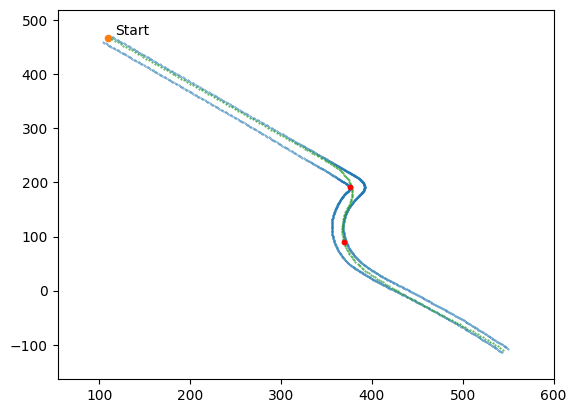

In [53]:
filter_for_track_section(fast_lap)
plot_track_2d(track)
plt.scatter(fast_lap['WORLDPOSX'], fast_lap['WORLDPOSY'], s=0.2)
plt.scatter(apex1[0], apex1[1], s=10, color= 'red')
plt.scatter(apex2[0], apex2[1], s=10, color= 'red')

384.9609375


,SESSION_IDENTIFIER,FRAME,LAP_NUM,SECTOR,LAP_DISTANCE,CURRENT_LAP_TIME_MS,SECTOR_1_TIME_MS,SECTOR_2_TIME_MS,LAP_TIME_MS,SECTOR_3_MS,SPEED_KPH,THROTTLE,BRAKE,GEAR,ENGINE_RPM,STEERING,YAW,PITCH,ROLL,WORLDPOSX,WORLDPOSY,WORLDPOSZ,WORLDFORWARDDIRX,WORLDFORWARDDIRY,WORLDFORWARDDIRZ,WORLDRIGHTDIRX,WORLDRIGHTDIRY,WORLDRIGHTDIRZ
821843,4486621736790789120.000000,10637,7,0,2.550781,16,28105,17743,80522.000000,34674.000000,309.000000,1.000000,0.000000,8.000000,11089.000000,0.000000,-2.334876,0.005268,-0.027038,114.113495,465.140747,2.881608,-23658.000000,-172.000000,-22670.000000,22658.000000,885.000000,-23652.000000
821844,4486621736790789120.000000,10638,7,0,6.853516,66,28105,17743,80522.000000,34674.000000,310.000000,1.000000,0.000000,8.000000,11092.000000,0.000000,-2.334840,0.005724,-0.027085,117.222603,462.162354,2.851288,-23658.000000,-187.000000,-22669.000000,22657.000000,887.000000,-23654.000000
821845,4486621736790789120.000000,10639,7,0,11.166016,116,28105,17743,80522.000000,34674.000000,310.000000,1.000000,0.000000,8.000000,11112.000000,0.000000,-2.334789,0.005830,-0.026652,120.337997,459.178345,2.822024,-23659.000000,-191.000000,-22668.000000,22656.000000,873.000000,-23655.000000
821846,4486621736790789120.000000,10640,7,0,15.501953,167,28105,17743,80522.000000,34674.000000,311.000000,1.000000,0.000000,8.000000,11133.000000,0.000000,-2.334713,0.005098,-0.025997,123.471466,456.177612,2.798616,-23661.000000,-167.000000,-22666.000000,22655.000000,851.000000,-23657.000000
821847,4486621736790789120.000000,10641,7,0,19.837891,216,28105,17743,80522.000000,34674.000000,311.000000,1.000000,0.000000,8.000000,11150.000000,0.000000,-2.334622,0.003775,-0.026019,126.604469,453.177643,2.776057,-23664.000000,-123.000000,-22664.000000,22654.000000,852.000000,-23658.000000


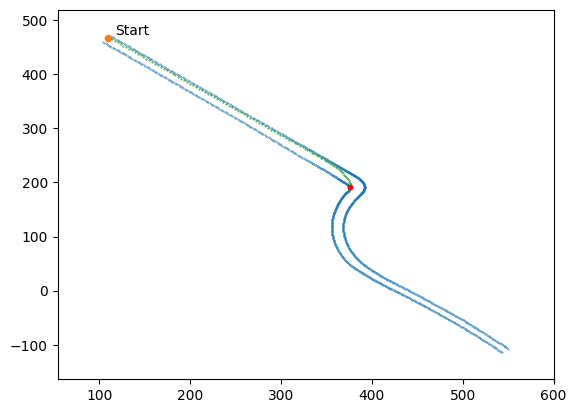

In [54]:
before_t1 = fast_lap[((fast_lap['WORLDPOSX'] <= apex1[0]) | (fast_lap['WORLDPOSY'] >= apex1[1])) & (fast_lap['LAP_DISTANCE'] < 400)]
filter_for_track_section(fast_lap)
plot_track_2d(track)
plt.scatter(before_t1['WORLDPOSX'], before_t1['WORLDPOSY'], s=0.2)
plt.scatter(apex1[0], apex1[1], s=10, color= 'red')
print(before_t1['LAP_DISTANCE'].max())
before_t1.head()

388.642578125


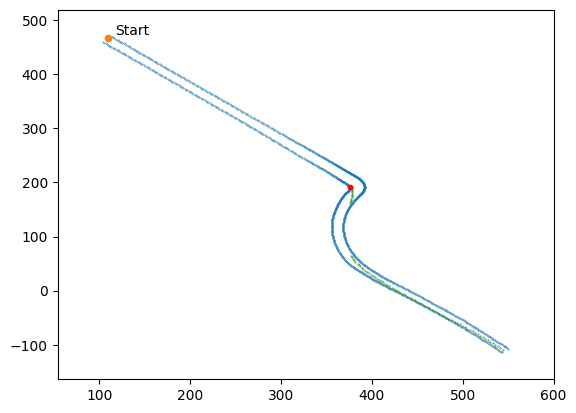

In [55]:
after_t1 = fast_lap[((fast_lap['WORLDPOSX'] > apex1[0]) & (fast_lap['WORLDPOSY'] < apex1[1])) & (fast_lap['LAP_DISTANCE'] > 300)]
filter_for_track_section(fast_lap)
plot_track_2d(track)
plt.scatter(after_t1['WORLDPOSX'], after_t1['WORLDPOSY'], s=0.2)
plt.scatter(apex1[0], apex1[1], s=10, color= 'red')
print(after_t1['LAP_DISTANCE'].min())

In [56]:
reduced_fast = fast_lap[(fast_lap['LAP_DISTANCE'] >= 370) & (fast_lap['LAP_DISTANCE'] <= 390)]
print(reduced_fast)

               SESSION_IDENTIFIER  FRAME  LAP_NUM  SECTOR  LAP_DISTANCE  CURRENT_LAP_TIME_MS  SECTOR_1_TIME_MS  SECTOR_2_TIME_MS  LAP_TIME_MS  SECTOR_3_MS  SPEED_KPH  THROTTLE    BRAKE     GEAR   ENGINE_RPM  STEERING       YAW     PITCH     ROLL  WORLDPOSX  WORLDPOSY  WORLDPOSZ  WORLDFORWARDDIRX  WORLDFORWARDDIRY  WORLDFORWARDDIRZ  WORLDRIGHTDIRX  WORLDRIGHTDIRY  WORLDRIGHTDIRZ
821937 4486621736790789120.000000  10753        7       0    371.408203                 4704             28105             17743 80522.000000 34674.000000 160.000000  0.000000 1.000000 4.000000  9324.000000  0.424616 -2.824404  0.008579 0.019829 374.490143 203.857132   2.133457     -10219.000000       -281.000000     -31131.000000    31128.000000     -649.000000   -10212.000000
821938 4486621736790789120.000000  10754        7       0    373.556641                 4754             28105             17743 80522.000000 34674.000000 158.000000  0.493646 0.000000 4.000000  9607.000000  0.426544 -2.856472  0.009295 0

In [57]:
df_diff = fast_lap.merge(before_t1, how='left', indicator=True)

# Filter rows that are only present in df1 (i.e., not in df2)
df_only_in_df1 = df_diff[df_diff['_merge'] == 'left_only']

# Drop the indicator column (_merge) if you no longer need it
df_only_in_df1 = df_only_in_df1.drop(columns=['_merge'])

# Display the result
df_only_in_df1.head()

,SESSION_IDENTIFIER,FRAME,LAP_NUM,SECTOR,LAP_DISTANCE,CURRENT_LAP_TIME_MS,SECTOR_1_TIME_MS,SECTOR_2_TIME_MS,LAP_TIME_MS,SECTOR_3_MS,SPEED_KPH,THROTTLE,BRAKE,GEAR,ENGINE_RPM,STEERING,YAW,PITCH,ROLL,WORLDPOSX,WORLDPOSY,WORLDPOSZ,WORLDFORWARDDIRX,WORLDFORWARDDIRY,WORLDFORWARDDIRZ,WORLDRIGHTDIRX,WORLDRIGHTDIRY,WORLDRIGHTDIRZ
100,4486621736790789120.000000,10759,7,0,388.642578,5004,28105,17743,80522.000000,34674.000000,162.000000,1.000000,0.000000,4.000000,10389.000000,0.425407,-3.017625,-0.009512,0.022232,377.692230,190.959152,2.082456,-4051.000000,311.000000,-32514.000000,32506.000000,-728.000000,-4057.000000
101,4486621736790789120.000000,10760,7,0,392.013672,5055,28105,17743,80522.000000,34674.000000,162.000000,1.000000,0.000000,4.000000,10148.000000,0.420644,-3.054096,-0.014731,0.020271,377.963104,188.713608,2.108801,-2863.000000,482.000000,-32638.000000,32634.000000,-664.000000,-2872.000000
102,4486621736790789120.000000,10761,7,0,395.046875,5105,28105,17743,80522.000000,34674.000000,163.000000,1.000000,0.000000,4.000000,10468.000000,0.419627,-3.090746,-0.019269,0.018941,378.152649,186.448715,2.146363,-1665.000000,631.000000,-32718.000000,32718.000000,-620.000000,-1677.000000
103,4486621736790789120.000000,10762,7,0,397.845703,5155,28105,17743,80522.000000,34674.000000,164.000000,1.000000,0.000000,4.000000,10336.000000,0.407304,-3.127950,-0.020727,0.018631,378.267609,184.165604,2.191318,-446.000000,679.000000,-32756.000000,32758.000000,-610.000000,-459.000000
104,4486621736790789120.000000,10763,7,0,399.828125,5205,28105,17743,80522.000000,34674.000000,165.000000,1.000000,0.000000,4.000000,10571.000000,0.398146,3.120042,-0.019668,0.019406,378.310913,181.871170,2.237487,705.000000,644.000000,-32753.000000,32753.000000,-635.000000,693.000000


388.642578125


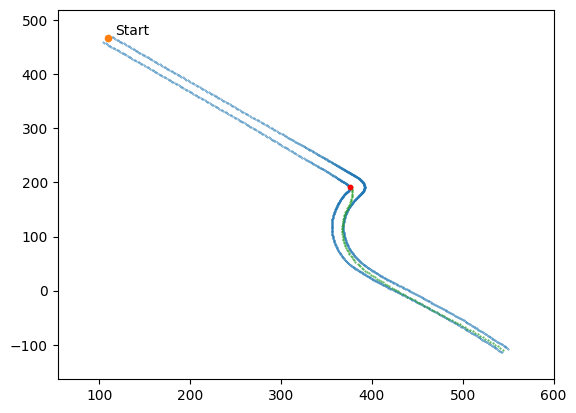

In [58]:
after_t1 = df_only_in_df1
filter_for_track_section(fast_lap)
plot_track_2d(track)
plt.scatter(after_t1['WORLDPOSX'], after_t1['WORLDPOSY'], s=0.2)
plt.scatter(apex1[0], apex1[1], s=10, color= 'red')
print(after_t1['LAP_DISTANCE'].min())

### APEX1 is somewhere between 384.9609375 and 388.642578125 in lap distance

In [59]:
(384.9609375+388.642578125)/2

386.8017578125

In [60]:
fast_lap = vector_to_apex(fast_lap, apex1, apex2)
fast_lap.head()

,SESSION_IDENTIFIER,FRAME,LAP_NUM,SECTOR,LAP_DISTANCE,CURRENT_LAP_TIME_MS,SECTOR_1_TIME_MS,SECTOR_2_TIME_MS,LAP_TIME_MS,SECTOR_3_MS,SPEED_KPH,THROTTLE,BRAKE,GEAR,ENGINE_RPM,STEERING,YAW,PITCH,ROLL,WORLDPOSX,WORLDPOSY,WORLDPOSZ,WORLDFORWARDDIRX,WORLDFORWARDDIRY,WORLDFORWARDDIRZ,WORLDRIGHTDIRX,WORLDRIGHTDIRY,WORLDRIGHTDIRZ,angle_to_apex1,angle_to_apex2
821843,4486621736790789120.000000,10637,7,0,2.550781,16,28105,17743,80522.000000,34674.000000,309.000000,1.000000,0.000000,8.000000,11089.000000,0.000000,-2.334876,0.005268,-0.027038,114.113495,465.140747,2.881608,-23658.000000,-172.000000,-22670.000000,22658.000000,885.000000,-23652.000000,133.281031,123.769984
821844,4486621736790789120.000000,10638,7,0,6.853516,66,28105,17743,80522.000000,34674.000000,310.000000,1.000000,0.000000,8.000000,11092.000000,0.000000,-2.334840,0.005724,-0.027085,117.222603,462.162354,2.851288,-23658.000000,-187.000000,-22669.000000,22657.000000,887.000000,-23654.000000,133.215573,123.619094
821845,4486621736790789120.000000,10639,7,0,11.166016,116,28105,17743,80522.000000,34674.000000,310.000000,1.000000,0.000000,8.000000,11112.000000,0.000000,-2.334789,0.005830,-0.026652,120.337997,459.178345,2.822024,-23659.000000,-191.000000,-22668.000000,22656.000000,873.000000,-23655.000000,133.175990,123.492428
821846,4486621736790789120.000000,10640,7,0,15.501953,167,28105,17743,80522.000000,34674.000000,311.000000,1.000000,0.000000,8.000000,11133.000000,0.000000,-2.334713,0.005098,-0.025997,123.471466,456.177612,2.798616,-23661.000000,-167.000000,-22666.000000,22655.000000,851.000000,-23657.000000,133.203279,123.430603
821847,4486621736790789120.000000,10641,7,0,19.837891,216,28105,17743,80522.000000,34674.000000,311.000000,1.000000,0.000000,8.000000,11150.000000,0.000000,-2.334622,0.003775,-0.026019,126.604469,453.177643,2.776057,-23664.000000,-123.000000,-22664.000000,22654.000000,852.000000,-23658.000000,133.278225,123.414874


In [61]:
before_t1 = vector_to_apex(before_t1, apex1, apex2)
before_t1.head()


,SESSION_IDENTIFIER,FRAME,LAP_NUM,SECTOR,LAP_DISTANCE,CURRENT_LAP_TIME_MS,SECTOR_1_TIME_MS,SECTOR_2_TIME_MS,LAP_TIME_MS,SECTOR_3_MS,SPEED_KPH,THROTTLE,BRAKE,GEAR,ENGINE_RPM,STEERING,YAW,PITCH,ROLL,WORLDPOSX,WORLDPOSY,WORLDPOSZ,WORLDFORWARDDIRX,WORLDFORWARDDIRY,WORLDFORWARDDIRZ,WORLDRIGHTDIRX,WORLDRIGHTDIRY,WORLDRIGHTDIRZ,angle_to_apex1,angle_to_apex2
821843,4486621736790789120.000000,10637,7,0,2.550781,16,28105,17743,80522.000000,34674.000000,309.000000,1.000000,0.000000,8.000000,11089.000000,0.000000,-2.334876,0.005268,-0.027038,114.113495,465.140747,2.881608,-23658.000000,-172.000000,-22670.000000,22658.000000,885.000000,-23652.000000,133.281031,123.769984
821844,4486621736790789120.000000,10638,7,0,6.853516,66,28105,17743,80522.000000,34674.000000,310.000000,1.000000,0.000000,8.000000,11092.000000,0.000000,-2.334840,0.005724,-0.027085,117.222603,462.162354,2.851288,-23658.000000,-187.000000,-22669.000000,22657.000000,887.000000,-23654.000000,133.215573,123.619094
821845,4486621736790789120.000000,10639,7,0,11.166016,116,28105,17743,80522.000000,34674.000000,310.000000,1.000000,0.000000,8.000000,11112.000000,0.000000,-2.334789,0.005830,-0.026652,120.337997,459.178345,2.822024,-23659.000000,-191.000000,-22668.000000,22656.000000,873.000000,-23655.000000,133.175990,123.492428
821846,4486621736790789120.000000,10640,7,0,15.501953,167,28105,17743,80522.000000,34674.000000,311.000000,1.000000,0.000000,8.000000,11133.000000,0.000000,-2.334713,0.005098,-0.025997,123.471466,456.177612,2.798616,-23661.000000,-167.000000,-22666.000000,22655.000000,851.000000,-23657.000000,133.203279,123.430603
821847,4486621736790789120.000000,10641,7,0,19.837891,216,28105,17743,80522.000000,34674.000000,311.000000,1.000000,0.000000,8.000000,11150.000000,0.000000,-2.334622,0.003775,-0.026019,126.604469,453.177643,2.776057,-23664.000000,-123.000000,-22664.000000,22654.000000,852.000000,-23658.000000,133.278225,123.414874


384.9609375


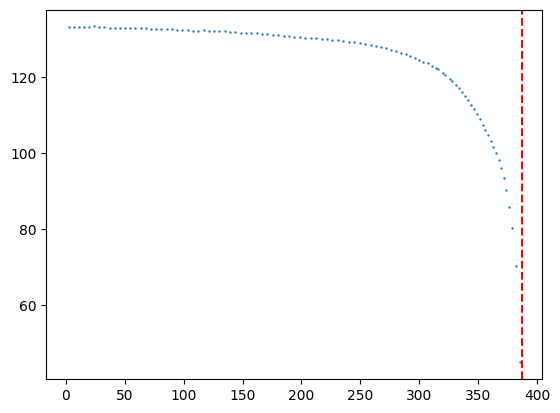

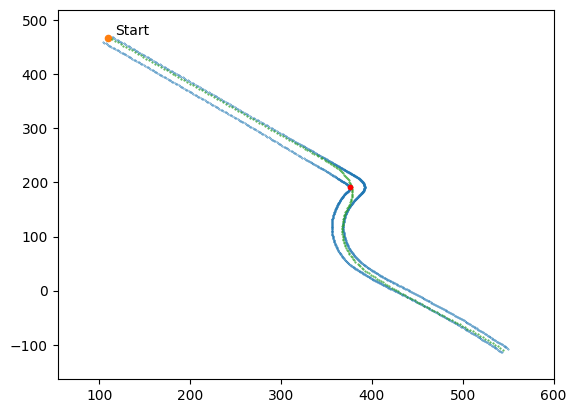

In [62]:
plt.scatter(before_t1['LAP_DISTANCE'], before_t1['angle_to_apex1'], s=0.5)
plt.axvline(x=386.8017578125, color='r', linestyle='--', label='apex1')
# plt.scatter(fast_lap['LAP_DISTANCE'], fast_lap['angle_to_apex2'], s=0.5, color = 'red')
# before_t1 = fast_lap[((fast_lap['WORLDPOSX'] <= apex1[0]) | (fast_lap['WORLDPOSY'] >= apex1[1])) & (fast_lap['LAP_DISTANCE'] < 400)]
filter_for_track_section(fast_lap)
plot_track_2d(track)
plt.scatter(fast_lap['WORLDPOSX'], fast_lap['WORLDPOSY'], s=0.2)
# plt.scatter(before_t1['WORLDPOSX'], before_t1['WORLDPOSY'], s=0.2)
plt.scatter(apex1[0], apex1[1], s=10, color= 'red')
print(before_t1['LAP_DISTANCE'].max())

494.794921875


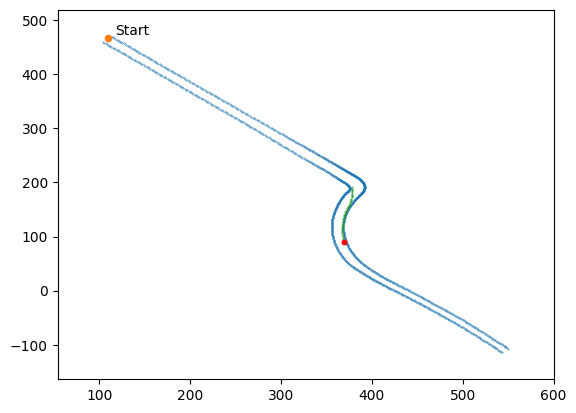

In [63]:
before_t2 = after_t1[((after_t1['WORLDPOSX'] <= apex2[0]) | (after_t1['WORLDPOSY'] >= apex2[1]))]
plot_track_2d(track)
plt.scatter(before_t2['WORLDPOSX'], before_t2['WORLDPOSY'], s=0.2)
# plt.scatter(before_t1['WORLDPOSX'], before_t1['WORLDPOSY'], s=0.2)
plt.scatter(apex2[0], apex2[1], s=10, color= 'red')
print(before_t2['LAP_DISTANCE'].max())

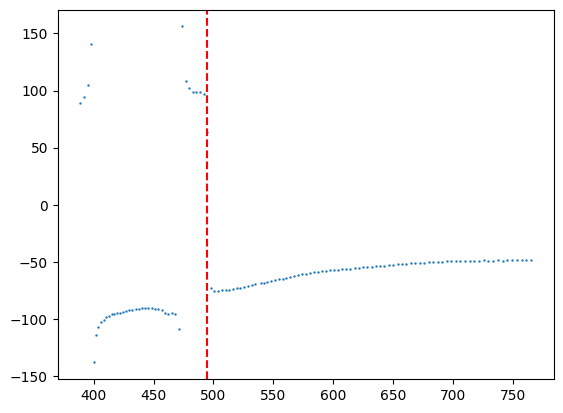

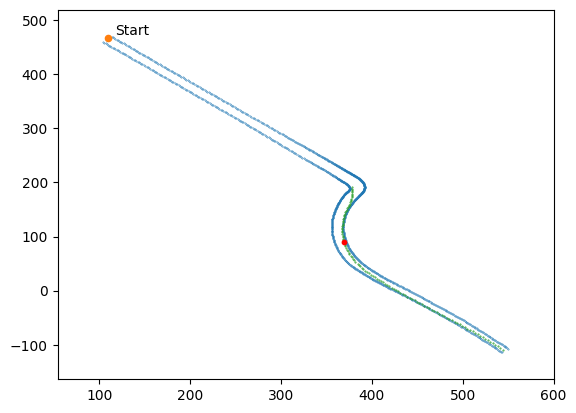

In [64]:
after_t1 = vector_to_apex(after_t1, apex1, apex2)
plt.scatter(after_t1['LAP_DISTANCE'], after_t1['angle_to_apex2'], s=0.5)
plt.axvline(x=494.794921875, color='r', linestyle='--', label='apex2')
# plt.scatter(fast_lap['LAP_DISTANCE'], fast_lap['angle_to_apex2'], s=0.5, color = 'red')
# before_t1 = fast_lap[((fast_lap['WORLDPOSX'] <= apex1[0]) | (fast_lap['WORLDPOSY'] >= apex1[1])) & (fast_lap['LAP_DISTANCE'] < 400)]
filter_for_track_section(fast_lap)
plot_track_2d(track)
plt.scatter(after_t1['WORLDPOSX'], after_t1['WORLDPOSY'], s=0.2)
# plt.scatter(before_t1['WORLDPOSX'], before_t1['WORLDPOSY'], s=0.2)
plt.scatter(apex2[0], apex2[1], s=10, color= 'red')

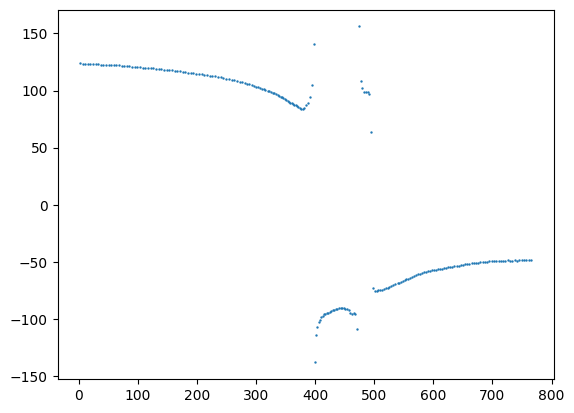

In [65]:
plt.scatter(fast_lap['LAP_DISTANCE'], fast_lap['angle_to_apex2'], s=0.5)

In [66]:
def sliding_angle(df: pd.DataFrame):
    df_new = df.copy()  # Use df.copy() to avoid mutating the original dataframe
    required_columns = ['WORLDFORWARDDIRX', 'WORLDFORWARDDIRY', 'WORLDPOSX', 'WORLDPOSY']

    # df_new['real_forward'] = 
    
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"DataFrame must contain the following columns: {required_columns}")

87226.0


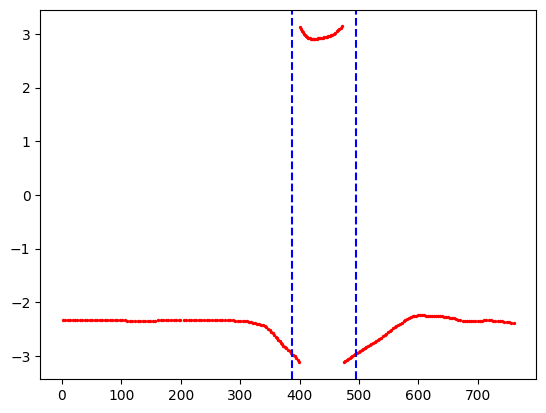

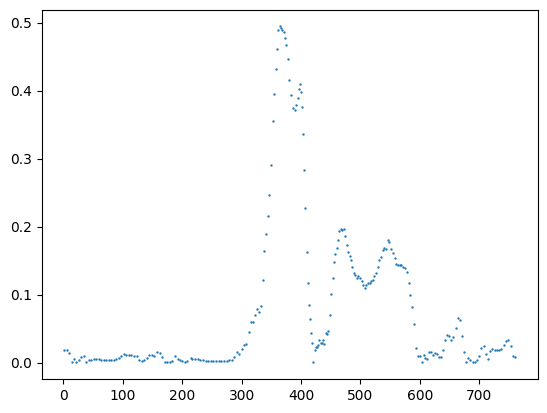

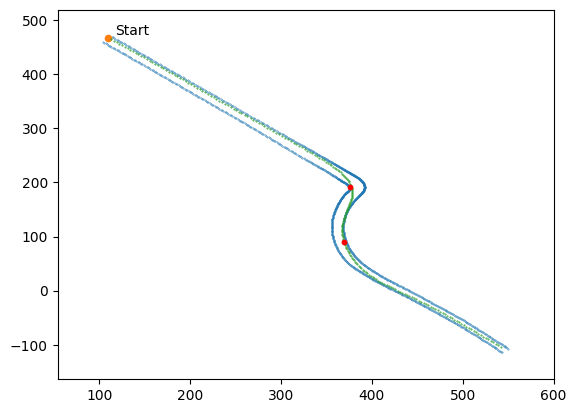

In [67]:
df = race_data23
# df = df.groupby(['SESSION_IDENTIFIER', 'LAP_NUM'])
def filterOneLap(data, sessionIndex):
    return data[(data.SESSION_IDENTIFIER == data.SESSION_IDENTIFIER.unique()[sessionIndex]) & (data.LAP_NUM == 1)].reset_index(drop=True)

data = filterOneLap(df, 0)
data['abs_yaw'] = abs(data['YAW'])
plt.scatter(data=data, x='LAP_DISTANCE', y='YAW', s=2, c='red')
plt.axvline(x=386.8017578125, color='b', linestyle='--', label='apex1')
plt.axvline(x=494.794921875, color='b', linestyle='--', label='apex2')

plt.figure()
abs_steering = abs(data['STEERING'])
plt.scatter(data['LAP_DISTANCE'], abs_steering, s=0.5)

plot_track_2d(track)
plt.scatter(data['WORLDPOSX'], data['WORLDPOSY'], s=0.2)
plt.scatter(apex1[0], apex1[1], s= 10, color = 'r')
plt.scatter(apex2[0], apex2[1], s= 10, color = 'r')

print(data['LAP_TIME_MS'].min())


In [68]:


def max_brake_pt(df: pd.DataFrame):
    df_new = df.copy()  # Use df.copy() to avoid mutating the original dataframe
    # required_columns = ['WORLDFORWARDDIRX', 'WORLDFORWARDDIRY', 'WORLDPOSX', 'WORLDPOSY']
    
    # if not all(col in df.columns for col in required_columns):
    #     raise ValueError(f"DataFrame must contain the following columns: {required_columns}")
    
    grouped = df.groupby(['SESSION_IDENTIFIER', 'LAP_NUM'])

    max_braking_points = []
    
    # Iterate through each group
    for (session_id, lap_num), group in grouped:
        # Find the first row with the maximum braking value
        max_braking_row = group.loc[group['BRAKE'].idxmax()]
        max_braking_points.append(max_braking_row)

    # Create a new DataFrame from the list of maximum braking points
    max_braking_df = pd.DataFrame(max_braking_points) #  columns=required_columns
    
    return max_braking_df
    
    

In [69]:
oui = load_race_data_2023(LOCAL_DATA_DIR)
oui = filter_for_track_section(oui)
oui.head()

,SESSION_IDENTIFIER,FRAME,LAP_NUM,SECTOR,LAP_DISTANCE,CURRENT_LAP_TIME_MS,SECTOR_1_TIME_MS,SECTOR_2_TIME_MS,LAP_TIME_MS,SECTOR_3_MS,SPEED_KPH,THROTTLE,BRAKE,GEAR,ENGINE_RPM,STEERING,YAW,PITCH,ROLL,WORLDPOSX,WORLDPOSY,WORLDPOSZ,WORLDFORWARDDIRX,WORLDFORWARDDIRY,WORLDFORWARDDIRZ,WORLDRIGHTDIRX,WORLDRIGHTDIRY,WORLDRIGHTDIRZ
0,10034676866664400896.000000,1680,1,0,1.775714,16,30129,18569,87226.000000,38528.000000,294.000000,1.000000,0.030945,8.000000,10541.000000,-0.018082,-2.336760,0.004231,-0.025839,113.192245,465.303589,2.900799,-23615.000000,-138.000000,-22714.000000,22704.000000,846.000000,-23610.000000
1,10034676866664400896.000000,1681,1,0,5.864580,66,30129,18569,87226.000000,38528.000000,294.000000,1.000000,0.030945,8.000000,10547.000000,-0.018174,-2.333671,0.005806,-0.025955,116.142723,462.470612,2.874730,-23685.000000,-190.000000,-22641.000000,22630.000000,850.000000,-23681.000000
2,10034676866664400896.000000,1682,1,0,9.964501,116,30129,18569,87226.000000,38528.000000,295.000000,1.000000,0.031952,8.000000,10563.000000,-0.013687,-2.330126,0.005979,-0.024798,119.108170,459.637115,2.845881,-23765.000000,-195.000000,-22557.000000,22547.000000,812.000000,-23761.000000
3,10034676866664400896.000000,1683,1,0,14.072903,166,30129,18569,87226.000000,38528.000000,295.000000,1.000000,0.032959,8.000000,10581.000000,-0.000687,-2.327518,0.005315,-0.024717,122.087158,456.805298,2.821898,-23824.000000,-174.000000,-22495.000000,22485.000000,809.000000,-23820.000000
4,10034676866664400896.000000,1684,1,0,18.184681,216,30129,18569,87226.000000,38528.000000,296.000000,1.000000,0.032959,8.000000,10598.000000,0.004532,-2.326889,0.004296,-0.025042,125.073685,453.976288,2.798889,-23838.000000,-140.000000,-22480.000000,22471.000000,820.000000,-23833.000000


In [70]:
oui = max_brake_pt(oui)
oui = oui[oui.BRAKE < 1]
print(oui)

                 SESSION_IDENTIFIER        FRAME  LAP_NUM   SECTOR  LAP_DISTANCE  CURRENT_LAP_TIME_MS  SECTOR_1_TIME_MS  SECTOR_2_TIME_MS   LAP_TIME_MS   SECTOR_3_MS  SPEED_KPH  THROTTLE    BRAKE     GEAR   ENGINE_RPM  STEERING       YAW     PITCH      ROLL  WORLDPOSX  WORLDPOSY  WORLDPOSZ  WORLDFORWARDDIRX  WORLDFORWARDDIRY  WORLDFORWARDDIRZ  WORLDRIGHTDIRX  WORLDRIGHTDIRY  WORLDRIGHTDIRZ
132264    122145520320873184.000000  2123.000000 1.000000 0.000000    512.934998         35569.000000      52455.000000      22833.000000 218185.000000 142897.000000   0.000000  0.097093 0.336187 0.000000  3517.000000 -0.628596  1.610878  0.011076  0.005322 359.736206  68.420280   2.813815      32738.000000       -362.000000      -1312.000000     1311.000000     -174.000000    32740.000000
135950    122145520320873184.000000  5875.000000 2.000000 0.000000    374.580078          4521.000000      11061.000000      25843.000000 165517.000000 128613.000000 218.000000  0.000000 0.331197 6.000000  9694.000

0.3311970829963684
          SESSION_IDENTIFIER  FRAME  LAP_NUM  SECTOR  LAP_DISTANCE  CURRENT_LAP_TIME_MS  SECTOR_1_TIME_MS  SECTOR_2_TIME_MS   LAP_TIME_MS   SECTOR_3_MS  SPEED_KPH  THROTTLE    BRAKE     GEAR   ENGINE_RPM  STEERING       YAW     PITCH      ROLL  WORLDPOSX  WORLDPOSY  WORLDPOSZ  WORLDFORWARDDIRX  WORLDFORWARDDIRY  WORLDFORWARDDIRZ  WORLDRIGHTDIRX  WORLDRIGHTDIRY  WORLDRIGHTDIRZ
0  122145520320873184.000000   5840        2       0    252.072754                 2886             11061             25843 165517.000000 128613.000000 310.000000  0.000000 0.086015 8.000000 10856.000000 -0.006546 -2.337292 -0.001249 -0.023256 293.724915 292.019897   1.768045     -23603.000000         40.000000     -22727.000000    22722.000000      761.000000   -23596.000000
1  122145520320873184.000000   5841        2       0    256.382812                 2936             11061             25843 165517.000000 128613.000000 308.000000  0.000000 0.097047 8.000000 10795.000000 -0.011582 -2.335553

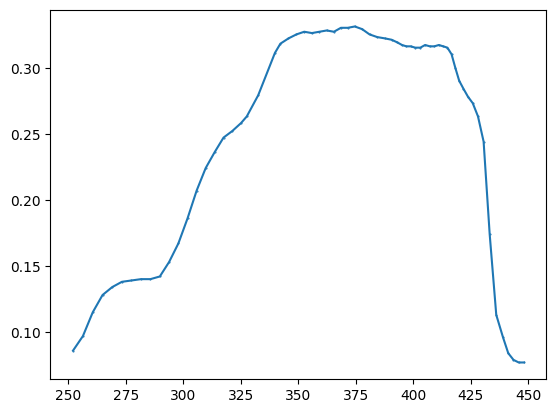

In [71]:
#122145520320873184, laps 1 and 2
df = race_data23
df = df[(df.SESSION_IDENTIFIER == 122145520320873184) & (df.LAP_NUM == 2) & (df.LAP_DISTANCE > 250) & (df.LAP_DISTANCE < 450)].reset_index(drop=True)
# df.head()
print(df.BRAKE.max())

print(df)

# plt.scatter(df['LAP_DISTANCE'], df['BRAKE'], s=0.5,linestyle='-')
plt.plot(df['LAP_DISTANCE'], df['BRAKE'], linestyle='-', marker='o', markersize=0.5)

In [72]:
df = df[df.BRAKE > 0.2]
print(df)

          SESSION_IDENTIFIER  FRAME  LAP_NUM  SECTOR  LAP_DISTANCE  CURRENT_LAP_TIME_MS  SECTOR_1_TIME_MS  SECTOR_2_TIME_MS   LAP_TIME_MS   SECTOR_3_MS  SPEED_KPH  THROTTLE    BRAKE     GEAR   ENGINE_RPM  STEERING       YAW     PITCH      ROLL  WORLDPOSX  WORLDPOSY  WORLDPOSZ  WORLDFORWARDDIRX  WORLDFORWARDDIRY  WORLDFORWARDDIRZ  WORLDRIGHTDIRX  WORLDRIGHTDIRY  WORLDRIGHTDIRZ
13 122145520320873184.000000   5853        2       0    305.823242                 3536             11061             25843 165517.000000 128613.000000 283.000000  0.000000 0.207095 8.000000  9912.000000  0.006821 -2.307633 -0.006142 -0.016679 333.024506 255.318359   1.908373     -24266.000000        201.000000     -22017.000000    22017.000000      546.000000   -24261.000000
14 122145520320873184.000000   5854        2       0    309.750977                 3586             11061             25843 165517.000000 128613.000000 281.000000  0.000000 0.224125 8.000000  9827.000000  0.014786 -2.308754 -0.006898 -0.01433

In [73]:
def max_steering_pt(df: pd.DataFrame):
    
    grouped = df.groupby(['SESSION_IDENTIFIER', 'LAP_NUM'])

    max_steering_points = []
    
    # Iterate through each group
    for (session_id, lap_num), group in grouped:
        # Find the first row with the maximum braking value
        max_steering_row = group.loc[abs(group['STEERING']).idxmax()]
        max_steering_points.append(max_steering_row)

    # Create a new DataFrame from the list of maximum braking points
    max_steering_df = pd.DataFrame(max_steering_points) #  columns=required_columns
    
    return max_steering_df

In [126]:
df = race_data23
df.head()
steer = max_steering_pt(df)
steer.head()

,SESSION_IDENTIFIER,FRAME,LAP_NUM,SECTOR,LAP_DISTANCE,CURRENT_LAP_TIME_MS,SECTOR_1_TIME_MS,SECTOR_2_TIME_MS,LAP_TIME_MS,SECTOR_3_MS,SPEED_KPH,THROTTLE,BRAKE,GEAR,ENGINE_RPM,STEERING,YAW,PITCH,ROLL,WORLDPOSX,WORLDPOSY,WORLDPOSZ,WORLDFORWARDDIRX,WORLDFORWARDDIRY,WORLDFORWARDDIRZ,WORLDRIGHTDIRX,WORLDRIGHTDIRY,WORLDRIGHTDIRZ
1115738,97185831637688192.000000,1092.000000,1.000000,0.000000,359.230286,4404.000000,29793.000000,18287.000000,94549.000000,46469.000000,169.000000,0.000000,0.000000,5.000000,8648.000000,1.000000,-2.588827,0.005249,0.026567,369.618530,216.297409,2.254571,-17203.000000,-171.000000,-27886.000000,27879.000000,-870.000000,-17194.000000
1119268,97185831637688192.000000,4647.000000,3.000000,0.000000,352.020508,4154.000000,28998.000000,18086.000000,83016.000000,35932.000000,189.000000,0.000000,1.000000,5.000000,9330.000000,1.000000,-2.565354,0.003100,0.026138,364.937653,221.832504,2.254687,-17853.000000,-101.000000,-27475.000000,27467.000000,-856.000000,-17845.000000
131820,122145520320873184.000000,1675.000000,1.000000,0.000000,436.554962,13163.000000,52455.000000,22833.000000,218185.000000,142897.000000,9.000000,1.000000,0.000000,1.000000,12980.000000,1.000000,-1.398991,-0.000066,0.001575,389.989563,136.502579,2.355145,-32284.000000,2.000000,5601.000000,-5601.000000,-51.000000,-32284.000000
135943,122145520320873184.000000,5868.000000,2.000000,0.000000,352.589355,4170.000000,11061.000000,25843.000000,165517.000000,128613.000000,244.000000,0.000000,0.327214,7.000000,9555.000000,0.495811,-2.533081,0.001125,0.025426,365.805847,221.905548,2.270334,-18731.000000,-36.000000,-26885.000000,26877.000000,-833.000000,-18724.000000
648293,206584597405881536.000000,1006.000000,1.000000,0.000000,363.824707,4521.000000,28964.000000,18239.000000,82903.000000,35700.000000,147.000000,0.000000,1.000000,4.000000,8400.000000,1.000000,-2.705436,0.008740,0.026364,372.044922,212.213089,2.230049,-13842.000000,-286.000000,-29698.000000,29692.000000,-863.000000,-13831.000000


In [75]:
steer = steer[(steer.STEERING < 0)]
steer.head()

,SESSION_IDENTIFIER,FRAME,LAP_NUM,SECTOR,LAP_DISTANCE,CURRENT_LAP_TIME_MS,SECTOR_1_TIME_MS,SECTOR_2_TIME_MS,LAP_TIME_MS,SECTOR_3_MS,SPEED_KPH,THROTTLE,BRAKE,GEAR,ENGINE_RPM,STEERING,YAW,PITCH,ROLL,WORLDPOSX,WORLDPOSY,WORLDPOSZ,WORLDFORWARDDIRX,WORLDFORWARDDIRY,WORLDFORWARDDIRZ,WORLDRIGHTDIRX,WORLDRIGHTDIRY,WORLDRIGHTDIRZ
82572,1119600813689253376.000000,3807.000000,1.000000,0.000000,514.931641,7621.000000,4061.000000,35729.000000,236297.000000,196507.000000,90.000000,0.000000,0.489311,2.000000,7455.000000,-1.000000,2.666066,-0.013127,-0.011620,377.382446,72.682510,2.501709,14999.000000,430.000000,-29129.000000,29127.000000,380.000000,15004.000000
156663,1265673112505406976.000000,2089.000000,1.000000,0.000000,565.818298,12963.000000,49000.000000,28510.000000,205917.000000,128407.000000,29.000000,1.000000,0.000000,1.000000,12960.000000,-1.000000,2.437272,-0.028290,0.002536,399.254456,27.836779,2.864411,21208.000000,926.000000,-24960.000000,24971.000000,-83.000000,21215.000000
753612,3468606918957231616.000000,4253.000000,1.000000,0.000000,536.205750,12178.000000,48691.000000,32660.000000,152593.000000,71242.000000,73.000000,0.000000,0.000000,2.000000,6384.000000,-1.000000,-2.596361,-0.003728,-0.019437,374.936981,47.354050,2.943205,-16993.000000,122.000000,-28015.000000,28011.000000,636.000000,-16988.000000
756637,3468606918957231616.000000,7296.000000,2.000000,0.000000,523.996582,10827.000000,10147.000000,33222.000000,176294.000000,132925.000000,104.000000,0.000000,0.000000,3.000000,7489.000000,-1.000000,-2.862337,-0.008879,-0.025783,374.291199,61.586830,2.731477,-9031.000000,290.000000,-31496.000000,31489.000000,844.000000,-9021.000000
810573,4471466212654297088.000000,1503.000000,1.000000,0.000000,512.651306,12495.000000,58916.000000,18245.000000,134705.000000,57544.000000,64.000000,0.000000,0.000000,-1.000000,10784.000000,-0.926848,0.497833,0.010233,0.007532,381.720947,76.741455,2.444827,15646.000000,-335.000000,28788.000000,-28790.000000,-246.000000,15644.000000


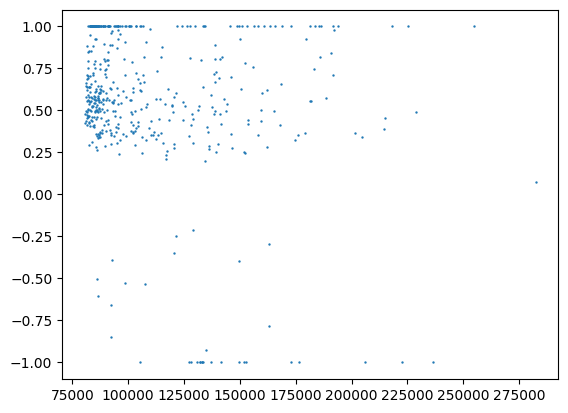

In [128]:
steer = max_steering_pt(df)
steer.head()
plt.scatter(steer.LAP_TIME_MS, steer.STEERING, s=0.5)

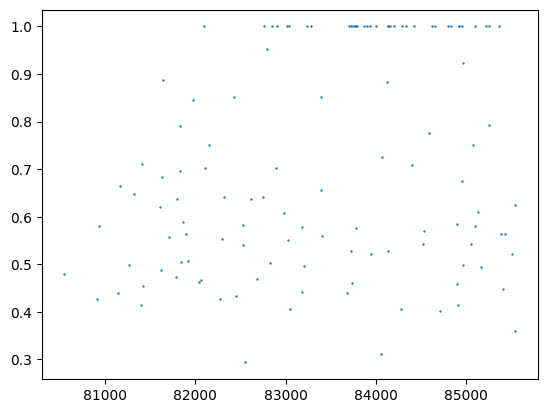

In [129]:
quantile_value = steer['LAP_TIME_MS'].quantile(0.25)
steer = steer[steer['LAP_TIME_MS'] <= quantile_value]
plt.scatter(steer.LAP_TIME_MS, steer.STEERING, s=0.5)

In [78]:
def find_first_steering_point(df: pd.DataFrame, threshold: float = 0.1):
    # Group by session and lap
    grouped = df.groupby(['SESSION_IDENTIFIER', 'LAP_NUM'])
    
    # Create a list to store the first row where steering > 0.1 for each lap
    first_steering_points = []
    
    # Iterate over each group
    for (session_id, lap_num), group in grouped:
        # Find the first row where the steering value is greater than the threshold (0.1)
        first_steering_row = group[group['STEERING'] > threshold].head(1)
        
        # If there is such a row, append it to the list
        if not first_steering_row.empty:
            first_steering_points.append(first_steering_row)
    
    # Concatenate all rows to form the new DataFrame
    steering_df = pd.concat(first_steering_points, ignore_index=True)
    
    return steering_df
    

In [79]:
df = race_data23
df.head()

,SESSION_IDENTIFIER,FRAME,LAP_NUM,SECTOR,LAP_DISTANCE,CURRENT_LAP_TIME_MS,SECTOR_1_TIME_MS,SECTOR_2_TIME_MS,LAP_TIME_MS,SECTOR_3_MS,SPEED_KPH,THROTTLE,BRAKE,GEAR,ENGINE_RPM,STEERING,YAW,PITCH,ROLL,WORLDPOSX,WORLDPOSY,WORLDPOSZ,WORLDFORWARDDIRX,WORLDFORWARDDIRY,WORLDFORWARDDIRZ,WORLDRIGHTDIRX,WORLDRIGHTDIRY,WORLDRIGHTDIRZ
0,10034676866664400896.000000,1680,1,0,1.775714,16,30129,18569,87226.000000,38528.000000,294.000000,1.000000,0.030945,8.000000,10541.000000,-0.018082,-2.336760,0.004231,-0.025839,113.192245,465.303589,2.900799,-23615.000000,-138.000000,-22714.000000,22704.000000,846.000000,-23610.000000
1,10034676866664400896.000000,1681,1,0,5.864580,66,30129,18569,87226.000000,38528.000000,294.000000,1.000000,0.030945,8.000000,10547.000000,-0.018174,-2.333671,0.005806,-0.025955,116.142723,462.470612,2.874730,-23685.000000,-190.000000,-22641.000000,22630.000000,850.000000,-23681.000000
2,10034676866664400896.000000,1682,1,0,9.964501,116,30129,18569,87226.000000,38528.000000,295.000000,1.000000,0.031952,8.000000,10563.000000,-0.013687,-2.330126,0.005979,-0.024798,119.108170,459.637115,2.845881,-23765.000000,-195.000000,-22557.000000,22547.000000,812.000000,-23761.000000
3,10034676866664400896.000000,1683,1,0,14.072903,166,30129,18569,87226.000000,38528.000000,295.000000,1.000000,0.032959,8.000000,10581.000000,-0.000687,-2.327518,0.005315,-0.024717,122.087158,456.805298,2.821898,-23824.000000,-174.000000,-22495.000000,22485.000000,809.000000,-23820.000000
4,10034676866664400896.000000,1684,1,0,18.184681,216,30129,18569,87226.000000,38528.000000,296.000000,1.000000,0.032959,8.000000,10598.000000,0.004532,-2.326889,0.004296,-0.025042,125.073685,453.976288,2.798889,-23838.000000,-140.000000,-22480.000000,22471.000000,820.000000,-23833.000000


In [80]:
first_steer = find_first_steering_point(df)
first_steer.head()

,SESSION_IDENTIFIER,FRAME,LAP_NUM,SECTOR,LAP_DISTANCE,CURRENT_LAP_TIME_MS,SECTOR_1_TIME_MS,SECTOR_2_TIME_MS,LAP_TIME_MS,SECTOR_3_MS,SPEED_KPH,THROTTLE,BRAKE,GEAR,ENGINE_RPM,STEERING,YAW,PITCH,ROLL,WORLDPOSX,WORLDPOSY,WORLDPOSZ,WORLDFORWARDDIRX,WORLDFORWARDDIRY,WORLDFORWARDDIRZ,WORLDRIGHTDIRX,WORLDRIGHTDIRY,WORLDRIGHTDIRZ
0,97185831637688192.000000,1084,1,0,339.766846,4003,29793,18287,94549.000000,46469.000000,190.000000,0.000000,1.000000,5.000000,9479.000000,0.172488,-2.378951,-0.008638,0.018445,357.337280,231.613037,2.217618,-22635.000000,283.000000,-23690.000000,23683.000000,-604.000000,-22636.000000
1,97185831637688192.000000,2973,2,0,326.379883,3737,28837,18406,82927.000000,35684.000000,230.000000,0.000000,1.000000,7.000000,8954.000000,0.146853,-2.347349,-0.010369,0.002067,347.883392,241.103485,2.084690,-23372.000000,339.000000,-22962.000000,22963.000000,-67.000000,-23374.000000
2,97185831637688192.000000,4640,3,0,332.125000,3803,28998,18086,83016.000000,35932.000000,223.000000,0.000000,1.000000,6.000000,9749.000000,0.160141,-2.365327,-0.009768,0.008986,351.929596,237.020645,2.141748,-22956.000000,320.000000,-23379.000000,23377.000000,-294.000000,-22958.000000
3,122145520320873184.000000,1492,1,0,349.416748,4020,52455,22833,218185.000000,142897.000000,290.000000,0.000000,0.150057,8.000000,10169.000000,0.102770,-2.417523,-0.004259,0.026360,363.669983,224.265076,2.257025,-21705.000000,139.000000,-24546.000000,24535.000000,-863.000000,-21701.000000
4,122145520320873184.000000,5860,2,0,325.111816,3787,11061,25843,165517.000000,128613.000000,271.000000,0.000000,0.258137,8.000000,9463.000000,0.107164,-2.329464,-0.011490,-0.000676,347.246552,242.269226,2.068161,-23779.000000,376.000000,-22540.000000,22542.000000,22.000000,-23780.000000


A plot of steering and braking points of all laps

,SESSION_IDENTIFIER,FRAME,LAP_NUM,SECTOR,LAP_DISTANCE,CURRENT_LAP_TIME_MS,SECTOR_1_TIME_MS,SECTOR_2_TIME_MS,LAP_TIME_MS,SECTOR_3_MS,SPEED_KPH,THROTTLE,BRAKE,GEAR,ENGINE_RPM,STEERING,YAW,PITCH,ROLL,WORLDPOSX,WORLDPOSY,WORLDPOSZ,WORLDFORWARDDIRX,WORLDFORWARDDIRY,WORLDFORWARDDIRZ,WORLDRIGHTDIRX,WORLDRIGHTDIRY,WORLDRIGHTDIRZ
count,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,513.000000,513.000000,513.000000,515.000000,515.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000
mean,9470541355402555392.000000,6776.081553,2.666019,0.000000,329.909404,4281.662136,33345.920388,21377.675728,108189.163107,53465.566990,205.341748,0.020036,0.723273,5.778641,9304.071845,0.119075,-2.388325,-0.007318,0.009870,349.468473,237.662099,2.132264,-22122.610136,239.352827,-23854.237817,23850.976608,-323.044834,-22122.155945
std,5520497973655652352.000000,8452.311629,2.691157,0.000000,33.332551,1180.796034,10323.120899,5884.226997,32365.830485,28859.078234,37.167196,0.095448,0.353004,1.195619,678.176481,0.016250,0.144736,0.003911,0.011617,24.026368,23.243574,0.106339,1502.225369,127.994164,3590.926848,3590.764625,380.355467,1502.858380
min,97185831637688192.000000,460.000000,1.000000,0.000000,2.590332,33.000000,252.000000,1273.000000,80522.000000,34620.000000,49.000000,0.000000,0.000000,0.000000,3517.000000,0.100101,-2.596219,-0.028759,-0.040040,111.395828,184.353485,1.672254,-25818.000000,-215.000000,-28013.000000,-32764.000000,-1016.000000,-25813.000000
25%,4308334336582110208.000000,2331.500000,1.000000,0.000000,327.080307,3837.000000,29179.500000,18340.500000,85377.000000,36772.000000,186.000000,0.000000,0.464271,5.000000,8953.500000,0.106997,-2.417794,-0.009950,0.003064,348.332748,231.529305,2.088993,-22906.000000,182.000000,-24551.000000,23423.000000,-599.000000,-22906.000000
50%,9674836166225879040.000000,4131.000000,2.000000,0.000000,333.089661,3954.000000,31070.000000,18978.000000,93317.000000,40115.000000,206.000000,0.000000,0.961654,6.000000,9330.000000,0.114611,-2.392416,-0.008387,0.010576,352.365936,235.822723,2.141466,-22298.000000,274.000000,-23993.000000,23983.000000,-346.000000,-22298.000000
75%,14587267502220027904.000000,6938.000000,3.000000,0.000000,339.403809,4201.500000,37449.500000,21350.000000,122925.000000,55517.000000,226.500000,0.000000,1.000000,7.000000,9621.000000,0.126574,-2.367153,-0.005556,0.018301,356.517029,240.619209,2.180861,-21695.000000,326.000000,-23421.000000,24544.000000,-100.000000,-21695.000000
max,18349591879748417536.000000,55734.000000,21.000000,0.000000,393.907196,14809.000000,59829.000000,57476.000000,254625.000000,196507.000000,325.000000,1.000000,1.000000,8.000000,12245.000000,0.204934,0.012561,0.006563,0.031033,387.583954,462.273193,2.964379,411.000000,942.000000,32759.000000,28007.000000,1311.000000,410.000000


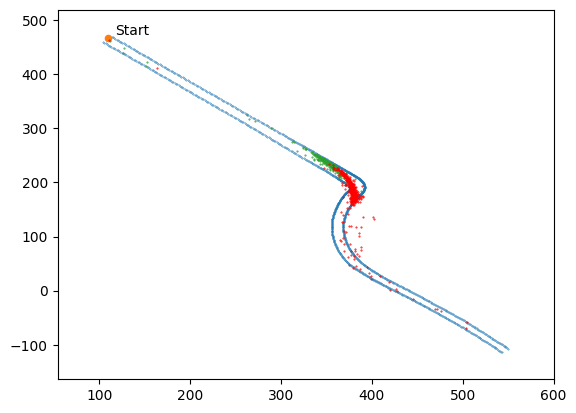

In [81]:
# all laps
df = race_data23
plot_track_2d(track)
# quantile_value = df['LAP_TIME_MS'].quantile(0.25)
# first_steer = first_steer[first_steer['LAP_TIME_MS'] <= quantile_value]
plt.scatter(first_steer.WORLDPOSX, first_steer.WORLDPOSY, s= 0.2)
max_steer = max_steering_pt(df)
# max_steer = max_steer[max_steer['LAP_TIME_MS'] <= quantile_value]
plt.scatter(max_steer.WORLDPOSX, max_steer.WORLDPOSY, s= 0.2, c= 'r')
first_steer.describe()

,SESSION_IDENTIFIER,FRAME,LAP_NUM,SECTOR,LAP_DISTANCE,CURRENT_LAP_TIME_MS,SECTOR_1_TIME_MS,SECTOR_2_TIME_MS,LAP_TIME_MS,SECTOR_3_MS,SPEED_KPH,THROTTLE,BRAKE,GEAR,ENGINE_RPM,STEERING,YAW,PITCH,ROLL,WORLDPOSX,WORLDPOSY,WORLDPOSZ,WORLDFORWARDDIRX,WORLDFORWARDDIRY,WORLDFORWARDDIRZ,WORLDRIGHTDIRX,WORLDRIGHTDIRY,WORLDRIGHTDIRZ
count,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,163.000000,163.000000,163.000000,164.000000,164.000000,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000
mean,8432984923654076416.000000,6721.579268,3.067073,0.000000,330.600409,3878.390244,29244.042683,18321.304878,83890.646341,36325.298780,209.365854,0.002991,0.921161,6.000000,9245.536585,0.122433,-2.381442,-0.009052,0.007488,350.765182,238.010334,2.124869,-22565.607362,296.147239,-23734.638037,23732.730061,-244.981595,-22566.496933
std,5620953015257677824.000000,7037.992790,2.099170,0.000000,8.411049,211.833263,776.870554,357.626401,1610.515608,967.467044,24.254789,0.015225,0.194742,0.806416,429.706183,0.017986,0.030603,0.002206,0.008772,5.701207,6.261901,0.068540,737.888959,72.252236,678.555545,676.828562,287.139177,738.658255
min,97185831637688192.000000,460.000000,1.000000,0.000000,277.250977,3153.000000,27629.000000,17651.000000,80522.000000,34620.000000,147.000000,0.000000,0.000000,4.000000,7607.000000,0.100101,-2.503019,-0.011952,-0.020333,313.568542,223.260147,1.786519,-23778.000000,-26.000000,-26310.000000,22542.000000,-861.000000,-23780.000000
25%,3240029861343644672.000000,2462.000000,2.000000,0.000000,326.724289,3787.000000,28709.000000,18061.500000,82544.250000,35628.750000,194.750000,0.000000,0.979778,6.000000,8927.750000,0.108583,-2.396281,-0.010435,0.002257,348.144653,234.713940,2.092213,-23083.500000,277.000000,-24078.000000,23252.500000,-417.500000,-23084.000000
50%,8553861956792471552.000000,4530.000000,2.000000,0.000000,331.501465,3868.000000,29187.500000,18310.000000,84031.000000,36231.000000,208.000000,0.000000,1.000000,6.000000,9270.500000,0.119568,-2.376436,-0.009701,0.008113,351.533020,237.559792,2.137842,-22695.000000,317.000000,-23633.000000,23630.000000,-265.000000,-22696.000000
75%,13475746705750861824.000000,8445.000000,4.000000,0.000000,335.150490,3957.250000,29753.000000,18489.000000,85144.250000,36906.750000,224.000000,0.000000,1.000000,7.000000,9544.750000,0.132675,-2.359829,-0.008474,0.012767,353.804825,241.117065,2.166796,-22221.000000,341.500000,-23252.000000,24077.500000,-73.500000,-22223.000000
max,17962844060030703616.000000,47040.000000,11.000000,0.000000,348.134277,5638.000000,32304.000000,19781.000000,86646.000000,39405.000000,278.000000,0.132479,1.000000,8.000000,10378.000000,0.204934,-2.329512,0.000801,0.026297,362.392975,276.320007,2.275432,-19530.000000,391.000000,-22542.000000,26302.000000,666.000000,-19525.000000


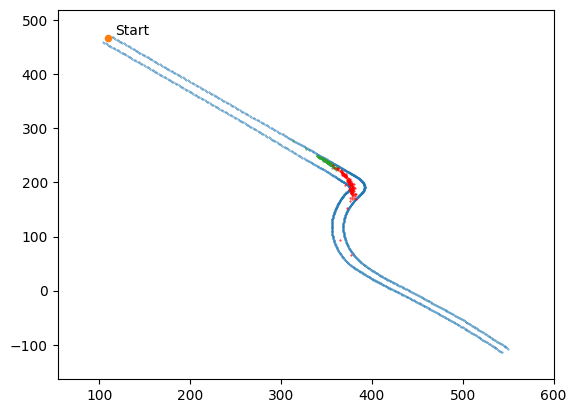

In [82]:
plot_track_2d(track)
quantile_value = df['LAP_TIME_MS'].quantile(0.25)
first_steer = first_steer[first_steer['LAP_TIME_MS'] <= quantile_value]
plt.scatter(first_steer.WORLDPOSX, first_steer.WORLDPOSY, s= 0.2)
max_steer = max_steering_pt(df)
max_steer = max_steer[max_steer['LAP_TIME_MS'] <= quantile_value]
plt.scatter(max_steer.WORLDPOSX, max_steer.WORLDPOSY, s= 0.2, c= 'r')
first_steer.describe()

# fast laps


### Finding the first steering threshold

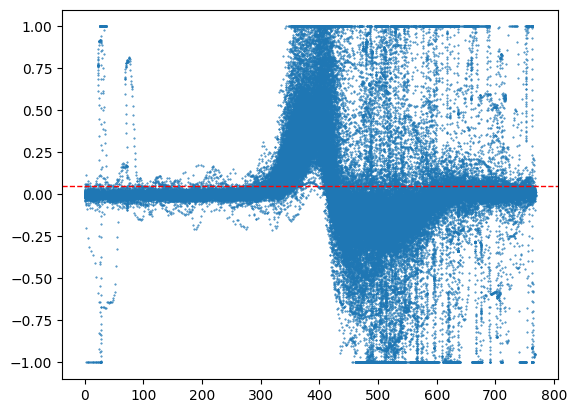

In [83]:

df = race_data23
# df = df[df['LAP_TIME_MS'] <= quantile_value]
plt.axhline(y=0.05, color='red', linestyle='--', linewidth=1)
plt.scatter(df.LAP_DISTANCE, df.STEERING, s= 0.2)

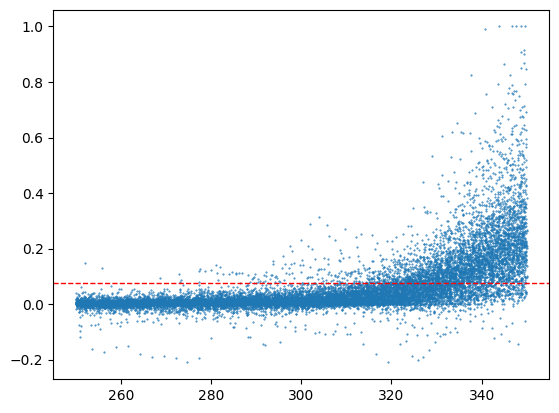

In [84]:
df = df[(df['LAP_DISTANCE'] <= 350) & (df['LAP_DISTANCE'] >= 250)]
plt.scatter(df.LAP_DISTANCE, df.STEERING, s= 0.2)
plt.axhline(y=0.075, color='red', linestyle='--', linewidth=1)

/Users/kiran/Library/Python/3.9/lib/python/site-packages/numpy/lib/polynomial.py:667: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/Users/kiran/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/var/folders/1z/8gdr4m5s3vnglmy5m5q4vrzh0000gn/T/ipykernel_16044/2288445992.py:7: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, 100)  # 3 for cubic


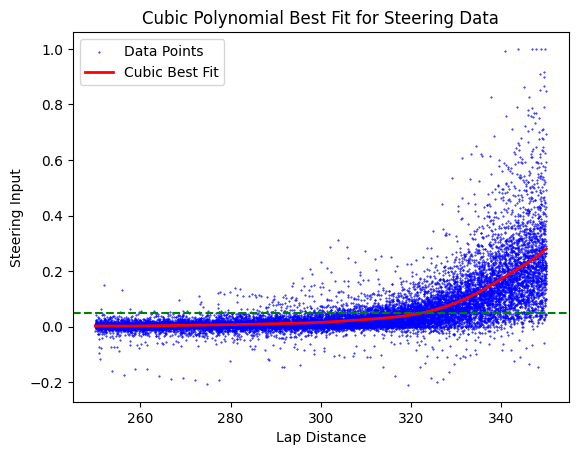

In [85]:
# df = df.sort_values

x = df['LAP_DISTANCE']
y = df['STEERING']

# Fit a cubic polynomial (degree 3) to the data
coefficients = np.polyfit(x, y, 100)  # 3 for cubic
cubic_poly = np.poly1d(coefficients)

# Generate x values for plotting the best fit curve
x_fit = np.linspace(min(x), max(x), 500)  # Create 500 points evenly spaced between min and max of x
y_fit = cubic_poly(x_fit)  # Evaluate the polynomial at these points

# Plot the original data points
plt.scatter(x, y, s=0.2, label='Data Points', color='blue')

# Plot the cubic polynomial best fit curve
plt.plot(x_fit, y_fit, label='Cubic Best Fit', color='red', linewidth=2)
plt.axhline(y=0.05, color='green', linestyle='--', linewidth=1.5)

# Labels and title
plt.xlabel('Lap Distance')
plt.ylabel('Steering Input')
plt.title('Cubic Polynomial Best Fit for Steering Data')

# Show legend
plt.legend()

# Show the plot
plt.show()


In [87]:
df = race_data23
df = vector_to_apex(df, apex1, apex2)
df.head()

,SESSION_IDENTIFIER,FRAME,LAP_NUM,SECTOR,LAP_DISTANCE,CURRENT_LAP_TIME_MS,SECTOR_1_TIME_MS,SECTOR_2_TIME_MS,LAP_TIME_MS,SECTOR_3_MS,SPEED_KPH,THROTTLE,BRAKE,GEAR,ENGINE_RPM,STEERING,YAW,PITCH,ROLL,WORLDPOSX,WORLDPOSY,WORLDPOSZ,WORLDFORWARDDIRX,WORLDFORWARDDIRY,WORLDFORWARDDIRZ,WORLDRIGHTDIRX,WORLDRIGHTDIRY,WORLDRIGHTDIRZ,angle_to_apex1,angle_to_apex2
0,10034676866664400896.000000,1680,1,0,1.775714,16,30129,18569,87226.000000,38528.000000,294.000000,1.000000,0.030945,8.000000,10541.000000,-0.018082,-2.336760,0.004231,-0.025839,113.192245,465.303589,2.900799,-23615.000000,-138.000000,-22714.000000,22704.000000,846.000000,-23610.000000,133.446400,123.936313
1,10034676866664400896.000000,1681,1,0,5.864580,66,30129,18569,87226.000000,38528.000000,294.000000,1.000000,0.030945,8.000000,10547.000000,-0.018174,-2.333671,0.005806,-0.025955,116.142723,462.470612,2.874730,-23685.000000,-190.000000,-22641.000000,22630.000000,850.000000,-23681.000000,133.295631,123.704226
2,10034676866664400896.000000,1682,1,0,9.964501,116,30129,18569,87226.000000,38528.000000,295.000000,1.000000,0.031952,8.000000,10563.000000,-0.013687,-2.330126,0.005979,-0.024798,119.108170,459.637115,2.845881,-23765.000000,-195.000000,-22557.000000,22547.000000,812.000000,-23761.000000,133.256963,123.582948
3,10034676866664400896.000000,1683,1,0,14.072903,166,30129,18569,87226.000000,38528.000000,295.000000,1.000000,0.032959,8.000000,10581.000000,-0.000687,-2.327518,0.005315,-0.024717,122.087158,456.805298,2.821898,-23824.000000,-174.000000,-22495.000000,22485.000000,809.000000,-23820.000000,133.278129,123.520257
4,10034676866664400896.000000,1684,1,0,18.184681,216,30129,18569,87226.000000,38528.000000,296.000000,1.000000,0.032959,8.000000,10598.000000,0.004532,-2.326889,0.004296,-0.025042,125.073685,453.976288,2.798889,-23838.000000,-140.000000,-22480.000000,22471.000000,820.000000,-23833.000000,133.327735,123.484745


In [88]:
df = race_data23
max_steer = max_brake_pt(df)
max_steer.head()

,SESSION_IDENTIFIER,FRAME,LAP_NUM,SECTOR,LAP_DISTANCE,CURRENT_LAP_TIME_MS,SECTOR_1_TIME_MS,SECTOR_2_TIME_MS,LAP_TIME_MS,SECTOR_3_MS,SPEED_KPH,THROTTLE,BRAKE,GEAR,ENGINE_RPM,STEERING,YAW,PITCH,ROLL,WORLDPOSX,WORLDPOSY,WORLDPOSZ,WORLDFORWARDDIRX,WORLDFORWARDDIRY,WORLDFORWARDDIRZ,WORLDRIGHTDIRX,WORLDRIGHTDIRY,WORLDRIGHTDIRZ
1115722,97185831637688192.000000,1076.000000,1.000000,0.000000,316.026581,3603.000000,29793.000000,18287.000000,94549.000000,46469.000000,238.000000,0.000000,1.000000,7.000000,9263.000000,0.004761,-2.345597,-0.009523,-0.008217,340.524109,248.391846,1.983378,-23412.000000,312.000000,-22921.000000,22923.000000,269.000000,-23411.000000
1117603,97185831637688192.000000,2961.000000,2.000000,0.000000,281.198242,3136.000000,28837.000000,18406.000000,82927.000000,35684.000000,313.000000,0.000000,1.000000,8.000000,10837.000000,0.000471,-2.337163,-0.004127,-0.018794,315.341370,272.467834,1.820060,-23606.000000,135.000000,-22724.000000,22722.000000,615.000000,-23600.000000
1119249,97185831637688192.000000,4628.000000,3.000000,0.000000,288.225586,3203.000000,28998.000000,18086.000000,83016.000000,35932.000000,305.000000,0.000000,1.000000,8.000000,10550.000000,0.004238,-2.341735,-0.004120,-0.018989,320.550354,267.742401,1.838880,-23502.000000,134.000000,-22832.000000,22830.000000,622.000000,-23496.000000
132264,122145520320873184.000000,2123.000000,1.000000,0.000000,512.934998,35569.000000,52455.000000,22833.000000,218185.000000,142897.000000,0.000000,0.097093,0.336187,0.000000,3517.000000,-0.628596,1.610878,0.011076,0.005322,359.736206,68.420280,2.813815,32738.000000,-362.000000,-1312.000000,1311.000000,-174.000000,32740.000000
135950,122145520320873184.000000,5875.000000,2.000000,0.000000,374.580078,4521.000000,11061.000000,25843.000000,165517.000000,128613.000000,218.000000,0.000000,0.331197,6.000000,9694.000000,0.371389,-2.703846,0.004901,0.020871,377.622009,202.770157,2.174471,-13889.000000,-160.000000,-29677.000000,29672.000000,-683.000000,-13883.000000


In [89]:
max_steer = max_steer[max_steer.STEERING < 0.05]
print(max_steer)

                 SESSION_IDENTIFIER       FRAME  LAP_NUM   SECTOR  LAP_DISTANCE  CURRENT_LAP_TIME_MS  SECTOR_1_TIME_MS  SECTOR_2_TIME_MS   LAP_TIME_MS   SECTOR_3_MS  SPEED_KPH  THROTTLE    BRAKE     GEAR   ENGINE_RPM  STEERING       YAW     PITCH      ROLL  WORLDPOSX  WORLDPOSY  WORLDPOSZ  WORLDFORWARDDIRX  WORLDFORWARDDIRY  WORLDFORWARDDIRZ  WORLDRIGHTDIRX  WORLDRIGHTDIRY  WORLDRIGHTDIRZ
1115722    97185831637688192.000000 1076.000000 1.000000 0.000000    316.026581          3603.000000      29793.000000      18287.000000  94549.000000  46469.000000 238.000000  0.000000 1.000000 7.000000  9263.000000  0.004761 -2.345597 -0.009523 -0.008217 340.524109 248.391846   1.983378     -23412.000000        312.000000     -22921.000000    22923.000000      269.000000   -23411.000000
1117603    97185831637688192.000000 2961.000000 2.000000 0.000000    281.198242          3136.000000      28837.000000      18406.000000  82927.000000  35684.000000 313.000000  0.000000 1.000000 8.000000 10837.000000

In [90]:
max_steering_df = df.loc[df.groupby(['SESSION_IDENTIFIER', 'LAP_NUM'])['STEERING'].idxmax()]
max_steering_df.head()

,SESSION_IDENTIFIER,FRAME,LAP_NUM,SECTOR,LAP_DISTANCE,CURRENT_LAP_TIME_MS,SECTOR_1_TIME_MS,SECTOR_2_TIME_MS,LAP_TIME_MS,SECTOR_3_MS,SPEED_KPH,THROTTLE,BRAKE,GEAR,ENGINE_RPM,STEERING,YAW,PITCH,ROLL,WORLDPOSX,WORLDPOSY,WORLDPOSZ,WORLDFORWARDDIRX,WORLDFORWARDDIRY,WORLDFORWARDDIRZ,WORLDRIGHTDIRX,WORLDRIGHTDIRY,WORLDRIGHTDIRZ
1115738,97185831637688192.000000,1092,1,0,359.230286,4404,29793,18287,94549.000000,46469.000000,169.000000,0.000000,0.000000,5.000000,8648.000000,1.000000,-2.588827,0.005249,0.026567,369.618530,216.297409,2.254571,-17203.000000,-171.000000,-27886.000000,27879.000000,-870.000000,-17194.000000
1117626,97185831637688192.000000,2984,2,0,357.022949,4287,28837,18406,82927.000000,35684.000000,177.000000,0.000000,1.000000,5.000000,8607.000000,1.000000,-2.646588,0.007542,0.026539,367.390076,217.179459,2.219646,-15565.000000,-247.000000,-28833.000000,28826.000000,-869.000000,-15554.000000
1119268,97185831637688192.000000,4647,3,0,352.020508,4154,28998,18086,83016.000000,35932.000000,189.000000,0.000000,1.000000,5.000000,9330.000000,1.000000,-2.565354,0.003100,0.026138,364.937653,221.832504,2.254687,-17853.000000,-101.000000,-27475.000000,27467.000000,-856.000000,-17845.000000
131820,122145520320873184.000000,1675,1,0,436.554962,13163,52455,22833,218185.000000,142897.000000,9.000000,1.000000,0.000000,1.000000,12980.000000,1.000000,-1.398991,-0.000066,0.001575,389.989563,136.502579,2.355145,-32284.000000,2.000000,5601.000000,-5601.000000,-51.000000,-32284.000000
135943,122145520320873184.000000,5868,2,0,352.589355,4170,11061,25843,165517.000000,128613.000000,244.000000,0.000000,0.327214,7.000000,9555.000000,0.495811,-2.533081,0.001125,0.025426,365.805847,221.905548,2.270334,-18731.000000,-36.000000,-26885.000000,26877.000000,-833.000000,-18724.000000


In [91]:
max_steering_df = max_steering_df[abs(max_steering_df.STEERING < 0.075)]
print(max_steering_df) 

                SESSION_IDENTIFIER  FRAME  LAP_NUM  SECTOR  LAP_DISTANCE  CURRENT_LAP_TIME_MS  SECTOR_1_TIME_MS  SECTOR_2_TIME_MS   LAP_TIME_MS   SECTOR_3_MS  SPEED_KPH  THROTTLE    BRAKE     GEAR  ENGINE_RPM  STEERING       YAW    PITCH     ROLL  WORLDPOSX  WORLDPOSY  WORLDPOSZ  WORLDFORWARDDIRX  WORLDFORWARDDIRY  WORLDFORWARDDIRZ  WORLDRIGHTDIRX  WORLDRIGHTDIRY  WORLDRIGHTDIRZ
446991 16481526976165060608.000000   1153        1       0    383.302032                14447             36585              7964 282369.000000 237820.000000  54.000000  0.165316 0.000000 1.000000 4822.000000  0.074144 -2.950861 0.008045 0.022248 376.512238 194.096619   2.266355      -6211.000000       -263.000000     -32171.000000    32165.000000     -728.000000    -6204.000000


In [92]:
df = race_data23
# df['LAP_TIME_MS'].describe()
min_lap_time = df['LAP_TIME_MS'].min()
fast_lap = df[df['LAP_TIME_MS'] == min_lap_time]

1 = 360.0
2 = 387.0
3 = 414.0
4 = 441.0
5 = 468.0
6 = 495.0
7 = 522.0
27.0


/var/folders/1z/8gdr4m5s3vnglmy5m5q4vrzh0000gn/T/ipykernel_16044/1032409562.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points_before['lap_dist_to_finish'] = points_before['LAP_DISTANCE'] - 387
/var/folders/1z/8gdr4m5s3vnglmy5m5q4vrzh0000gn/T/ipykernel_16044/1032409562.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points_before['lap_dist_to_finish'] = points_before['LAP_DISTANCE'] - x
/var/folders/1z/8gdr4m5s3vnglmy5m5q4vrzh0000gn/T/ipykernel_16044/1032409562.py:37: SettingWithCopyWarning: 
A

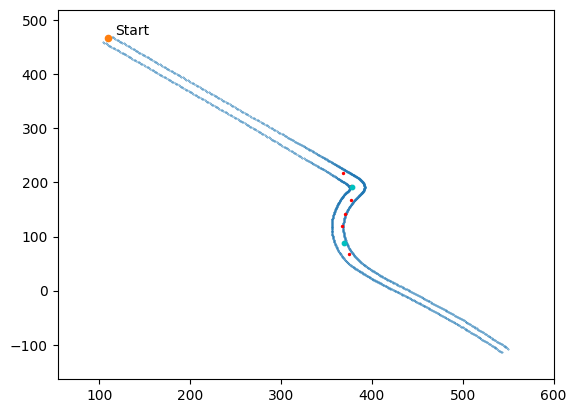

In [93]:
# lap distance of apexes:
fast_lap = df[df['LAP_TIME_MS'] == min_lap_time]
points_before = fast_lap[fast_lap['LAP_DISTANCE'] > 387]
points_before['lap_dist_to_finish'] = points_before['LAP_DISTANCE'] - 387
closest_point_before = points_before.loc[points_before.groupby(['SESSION_IDENTIFIER', 'LAP_NUM'])['lap_dist_to_finish'].idxmin()]
# apex1 387
# apex2 495
plot_track_2d(track)

def scatters(df: pd.DataFrame, first, last):
    step = (last - first)/4
    x = first - step
    count = 1
    while x <= last + step + 1:
        fast_lap = df.copy()
        points_before = fast_lap[fast_lap['LAP_DISTANCE'] < x]
        points_before['lap_dist_to_finish'] = points_before['LAP_DISTANCE'] - x
        closest_point_before = points_before.loc[points_before.groupby(['SESSION_IDENTIFIER', 'LAP_NUM'])['lap_dist_to_finish'].idxmax()]
        lapdist = closest_point_before['LAP_DISTANCE']
        print(f"{count} = {x}")
        plt.scatter(closest_point_before.WORLDPOSX, closest_point_before.WORLDPOSY, s= 2, c = 'r')
        x = x + step
        count = count + 1
    print(step)

scatters(fast_lap, 387, 495)


points_before = fast_lap[fast_lap['LAP_DISTANCE'] > 495]
points_before['lap_dist_to_finish'] = points_before['LAP_DISTANCE'] - 495
closest_point_before = points_before.loc[points_before.groupby(['SESSION_IDENTIFIER', 'LAP_NUM'])['lap_dist_to_finish'].idxmin()]
plt.scatter(closest_point_before.WORLDPOSX, closest_point_before.WORLDPOSY, s= 10, c = 'c')
points_before = fast_lap[fast_lap['LAP_DISTANCE'] > 387]
points_before['lap_dist_to_finish'] = points_before['LAP_DISTANCE'] - 387
closest_point_before = points_before.loc[points_before.groupby(['SESSION_IDENTIFIER', 'LAP_NUM'])['lap_dist_to_finish'].idxmin()]
plt.scatter(closest_point_before.WORLDPOSX, closest_point_before.WORLDPOSY, s= 10, c = 'c')



step = 27   
1 = 360.0    
2 = 387.0   
3 = 414.0   
4 = 441.0   
5 = 468.0   
6 = 495.0   
7 = 522.0   

In [95]:
df = race_data23
df.head()

,SESSION_IDENTIFIER,FRAME,LAP_NUM,SECTOR,LAP_DISTANCE,CURRENT_LAP_TIME_MS,SECTOR_1_TIME_MS,SECTOR_2_TIME_MS,LAP_TIME_MS,SECTOR_3_MS,SPEED_KPH,THROTTLE,BRAKE,GEAR,ENGINE_RPM,STEERING,YAW,PITCH,ROLL,WORLDPOSX,WORLDPOSY,WORLDPOSZ,WORLDFORWARDDIRX,WORLDFORWARDDIRY,WORLDFORWARDDIRZ,WORLDRIGHTDIRX,WORLDRIGHTDIRY,WORLDRIGHTDIRZ
0,10034676866664400896.000000,1680,1,0,1.775714,16,30129,18569,87226.000000,38528.000000,294.000000,1.000000,0.030945,8.000000,10541.000000,-0.018082,-2.336760,0.004231,-0.025839,113.192245,465.303589,2.900799,-23615.000000,-138.000000,-22714.000000,22704.000000,846.000000,-23610.000000
1,10034676866664400896.000000,1681,1,0,5.864580,66,30129,18569,87226.000000,38528.000000,294.000000,1.000000,0.030945,8.000000,10547.000000,-0.018174,-2.333671,0.005806,-0.025955,116.142723,462.470612,2.874730,-23685.000000,-190.000000,-22641.000000,22630.000000,850.000000,-23681.000000
2,10034676866664400896.000000,1682,1,0,9.964501,116,30129,18569,87226.000000,38528.000000,295.000000,1.000000,0.031952,8.000000,10563.000000,-0.013687,-2.330126,0.005979,-0.024798,119.108170,459.637115,2.845881,-23765.000000,-195.000000,-22557.000000,22547.000000,812.000000,-23761.000000
3,10034676866664400896.000000,1683,1,0,14.072903,166,30129,18569,87226.000000,38528.000000,295.000000,1.000000,0.032959,8.000000,10581.000000,-0.000687,-2.327518,0.005315,-0.024717,122.087158,456.805298,2.821898,-23824.000000,-174.000000,-22495.000000,22485.000000,809.000000,-23820.000000
4,10034676866664400896.000000,1684,1,0,18.184681,216,30129,18569,87226.000000,38528.000000,296.000000,1.000000,0.032959,8.000000,10598.000000,0.004532,-2.326889,0.004296,-0.025042,125.073685,453.976288,2.798889,-23838.000000,-140.000000,-22480.000000,22471.000000,820.000000,-23833.000000


Looking at null values that cause angle_to_apex nulls

In [108]:
df_with_nulls = df[df.isnull().any(axis=1)]
# df_with_nulls = df_with_nulls[['SESSION_IDENTIFIER', 'LAP_TIME_MS']]
# nulls_grouped = df_with_nulls.groupby(['SESSION_IDENTIFIER'])
# df_with_nulls = df_with_nulls[df_with_nulls['YAW', 'PITCH', 'ROLL', 'WORLDPOSZ', 'WORLDFORWARDDIRX', 'WORLDFORWARDDIRY', 'WORLDFORWARDDIRZ', 'WORLDRIGHTDIRX', 'WORLDRIGHTDIRY', 'WORLDRIGHTDIRZ'].isnotnull()]
# df_with_nulls.describe()
# df_with_nulls = df_with_nulls.groupby(['SESSION_IDENTIFIER', 'LAP_TIME_MS'])
print(df_with_nulls)

# print(nulls_grouped)


                SESSION_IDENTIFIER  FRAME  LAP_NUM  SECTOR  LAP_DISTANCE  CURRENT_LAP_TIME_MS  SECTOR_1_TIME_MS  SECTOR_2_TIME_MS  LAP_TIME_MS  SECTOR_3_MS  SPEED_KPH  THROTTLE    BRAKE     GEAR   ENGINE_RPM  STEERING  YAW  PITCH  ROLL  WORLDPOSX   WORLDPOSY  WORLDPOSZ  WORLDFORWARDDIRX  WORLDFORWARDDIRY  WORLDFORWARDDIRZ  WORLDRIGHTDIRX  WORLDRIGHTDIRY  WORLDRIGHTDIRZ
9751   10419879221391935488.000000    641        1       0      1.415350                    0             29773             18687 84982.000000 36522.000000 311.000000  1.000000 0.000000 8.000000 11137.000000  0.000000  NaN    NaN   NaN 113.770683  466.421265        NaN               NaN               NaN               NaN             NaN             NaN             NaN
9756   10419879221391935488.000000    646        1       0     23.116512                  250             29773             18687 84982.000000 36522.000000 313.000000  1.000000 0.000000 8.000000 11213.000000  0.000000  NaN    NaN   NaN 129.396393  451.3386

In [100]:
# print(df_with_nulls)
unique_session_identifiers = df_with_nulls['SESSION_IDENTIFIER'].unique()
print(unique_session_identifiers)

[1.04198792e+19 1.17679992e+19 4.48662174e+18]


In [119]:
merge = race_data23
merge_new = merge[merge.WORLDFORWARDDIRX.isna()]
merge_new


,SESSION_IDENTIFIER,FRAME,LAP_NUM,SECTOR,LAP_DISTANCE,CURRENT_LAP_TIME_MS,SECTOR_1_TIME_MS,SECTOR_2_TIME_MS,LAP_TIME_MS,SECTOR_3_MS,SPEED_KPH,THROTTLE,BRAKE,GEAR,ENGINE_RPM,STEERING,YAW,PITCH,ROLL,WORLDPOSX,WORLDPOSY,WORLDPOSZ,WORLDFORWARDDIRX,WORLDFORWARDDIRY,WORLDFORWARDDIRZ,WORLDRIGHTDIRX,WORLDRIGHTDIRY,WORLDRIGHTDIRZ
11124,10419879221391935488.000000,2346,2,0,1.549316,16,29188,18052,82449.000000,35209.000000,308.000000,1.000000,0.000000,8.000000,11057.000000,0.045390,NaN,NaN,NaN,113.807060,466.265808,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11125,10419879221391935488.000000,2347,2,0,5.841797,66,29188,18052,82449.000000,35209.000000,309.000000,1.000000,0.000000,8.000000,11059.000000,0.013957,NaN,NaN,NaN,116.986862,463.374664,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11126,10419879221391935488.000000,2348,2,0,10.135254,116,29188,18052,82449.000000,35209.000000,309.000000,1.000000,0.000000,8.000000,11077.000000,0.000000,NaN,NaN,NaN,120.147934,460.461975,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11127,10419879221391935488.000000,2349,2,0,14.437012,166,29188,18052,82449.000000,35209.000000,310.000000,1.000000,0.000000,8.000000,11093.000000,0.000000,NaN,NaN,NaN,123.299789,457.527771,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11128,10419879221391935488.000000,2350,2,0,18.747070,216,29188,18052,82449.000000,35209.000000,310.000000,1.000000,0.000000,8.000000,11113.000000,0.000000,NaN,NaN,NaN,126.448509,454.578094,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130167,11767999155862376448.000000,623,1,0,754.028748,10627,27834,18078,81138.000000,35226.000000,286.000000,1.000000,0.000000,7.000000,11534.000000,0.005672,NaN,NaN,NaN,535.391174,-101.663010,NaN,NaN,NaN,NaN,NaN,NaN,NaN
818777,4486621736790789120.000000,7251,5,0,216.023438,2418,28163,18599,83686.000000,36924.000000,330.000000,1.000000,0.000000,8.000000,11804.000000,0.000000,NaN,NaN,NaN,268.476105,317.695862,NaN,NaN,NaN,NaN,NaN,NaN,NaN
818827,4486621736790789120.000000,7301,5,0,380.322266,4922,28163,18599,83686.000000,36924.000000,159.000000,0.863148,0.000000,4.000000,10145.000000,0.411342,NaN,NaN,NaN,376.963135,196.527695,NaN,NaN,NaN,NaN,NaN,NaN,NaN
818877,4486621736790789120.000000,7351,5,0,515.976562,7423,28163,18599,83686.000000,36924.000000,217.000000,1.000000,0.000000,5.000000,11593.000000,-0.081982,NaN,NaN,NaN,374.186371,70.356575,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [130]:
# Create a temporary DataFrame that only contains matching rows
null_laps = merge[merge.WORLDFORWARDDIRX.isna()][['SESSION_IDENTIFIER', 'LAP_NUM']].drop_duplicates().copy()

print(null_laps)




                SESSION_IDENTIFIER  LAP_NUM
11124  10419879221391935488.000000        2
12773  10419879221391935488.000000        3
129957 11767999155862376448.000000        1
818777  4486621736790789120.000000        5
